In [218]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
%matplotlib inline
import os
import yaml
from yaml import CLoader as Loader
from glob import glob
import regex as re

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

LOG_PATH = '../logs/'
DL_LOG_PATH = '../dl_logs/'


In [221]:
def parse_tb_logs(logs_path, metrics_to_plot, threshold=0.75):
    values = defaultdict(list)
    print("www", logs_path)
    if os.path.isdir(join(logs_path, "metrics_synth")):
        metrics_path = join(logs_path, "metrics_synth")
    elif os.path.isdir(join(logs_path, "metrics")):
        metrics_path = join(logs_path, "metrics")
    else:
        print("ERR: logs not found")
        return [], []
        
    list_folds = os.listdir(metrics_path)
    list_folds = [el for el in list_folds if "DS_Store" not in el]
    #print(list_folds)
                              
    for fold_path in list_folds:
        logs_fold_path = join(metrics_path, fold_path)
        match = re.search("fold_([0-9])", fold_path)
        fold_nb = int(match[0][-1])
        fold_string=f"fold_{fold_nb}"
        print(fold_string,  end = ' ')

        event_acc = EventAccumulator(logs_fold_path)
        event_acc.Reload()
        
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                print(f'{tag} {len(vals)}, ',  end = '')
                if tag == 'val_acc':
                    print(f"Max_acc: {max(vals):.3}", end=" ")
                if len(vals) < 2 or ('acc' in tag and max(vals) < threshold):
                    print(f"{bcolors.FAIL}unsuccessful run{bcolors.ENDC}")
                    return defaultdict(list), dict()
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"{bcolors.WARNING}warning: {tag} not in logs{bcolors.ENDC}", end=" ")
                #values[tag].append([])
                pass
        print()
    print()
        
    with open(join(logs_fold_path, 'hparams.yaml')) as file:
        hparams_list = yaml.load(file, Loader=Loader)
    
    fold_ckpts = [y for x in os.walk(logs_path) for y in glob(os.path.join(x[0], '*.ckpt'))]
    best_epochs = []
    patt_to_find = 'epoch='
    for fold_ckpt in fold_ckpts:
        idx_beg=fold_ckpt.rfind(patt_to_find)
        idx_end=fold_ckpt[idx_beg+1:].find('_')+idx_beg
        best_epochs.append(int(fold_ckpt[idx_beg+len(patt_to_find):idx_end+1]))
    #print("best ep", hparams_list)
    
    if len(best_epochs) > 0: hparams_list['best_epoch'] = int(np.mean(best_epochs))
    hparams_list.pop('args', None)
        
    return values, hparams_list

def interpolate_values(metrics_to_plot, values, x_values, tot_num_values=100):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        val_cond = 'val' in metric_name
        x_values = x_values if val_cond else values[f'{metric_name}_step']
        #print('max_epochs_real', max_epochs_real, val_epochs_logged)
        max_epochs_real = max(max(x_values)) 
        #max_epochs = min(max_epochs, max_epochs_real)
        x = np.linspace(0, max_epochs_real, num=tot_num_values)
        temp_lists=[]
        if val_cond:
            metric_log_steps = x_values
            #metric_log_steps = [list(set(el)) for el in metric_log_steps]
        else:
            metric_log_steps = values[f'{metric_name}_step']
        
        for steps, vals in zip(metric_log_steps, values[metric_name]):
            steps = steps[:len(vals)]
            temp_lists.append(np.interp(x, steps, vals))
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(temp_lists, axis=0)
        interp_values[f'{metric_name}_interp_var'] = np.var(temp_lists, axis=0)
    
    return interp_values

def plot_metrics(metrics_to_plot, interp_values_df, ax, label, epochs_values=None, color=None):
    
    for i, metric_name in enumerate(metrics_to_plot):
        if epochs_values == None:
            epochs = interp_values_df[f'{metric_name}_interp_steps']
        else:
            epochs = np.linspace(0, max(max(epochs_values)), interp_values_df.shape[0])
            #print("max val ep: ", max(epochs)) 
        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        ax[i].plot(epochs, mean_val, label=label, color=color) #, yerr=var_val)
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor='k')
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("steps")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(interp_values_df.shape[0]) * 0.95, '--k', linewidth=1, alpha=0.1)
        
    return ax

def plot_agg_metrics(metrics_to_plot, logs_paths, checkpoints, 
                     name: str=None, tot_num_values=200, 
                     plot_legend=0, val_epochs_logged=False, threshold=0.75, 
                     xlabel='rel_steps', color_patt=None):
    rejected_ckpts=[]
    highscore_table = []
    f,a = plt.subplots(1, len(metrics_to_plot)-1)
    f.set_size_inches(20,6)
    f.tight_layout()
    plt.ylim(0,1.1)
    is_labeled = np.zeros(10)
    tot_len_ckpt = len(logs_paths)
    if color_patt == 'discrete':
        cmap = plt.get_cmap('Dark2')
        
    for i, (logs_path, ckpt_name) in enumerate(zip(logs_paths, checkpoints)):
        print(ckpt_name)
        match=re.search(re.compile("_d([0-9]*)"), ckpt_name)
        depth=int(match.group(1)) 
        match=re.search(re.compile("_b([0-9]*)"), ckpt_name)
        b_len=int(match.group(1)) 

        metric_values, hparams_list = parse_tb_logs(logs_path, metrics_to_plot,
                                                    threshold=threshold)
        if len(list(metric_values)) == 0: 
            rejected_ckpts.append(ckpt_name)
            continue
            
        def create_run_dict(hparams_list, metric_values, ckpt_name):
            hparams_list['name'] = ckpt_name
            hparams_list['eval_steps'] = []
            hparams_list['best_score'] = max(max(metric_values['val_acc']))
            return hparams_list
        
        highscore_table.append(create_run_dict(hparams_list, metric_values, ckpt_name))   
        val_epochs_logged = 'val_epoch' in metric_values.keys()
        if 'epoch' in xlabel and val_epochs_logged:
            x_values = metric_values['val_epoch']
        else:
            x_values = metric_values['val_loss_step']
            if b_len > 0: 
                res=[]
                for fold_vals in x_values:
                    fold_vals.insert(0, 0)
                    res.append([fold_vals[i] - fold_vals[i-1] for i in range(1, len(fold_vals))])
                x_values=res
        
        interp_values = interpolate_values(metrics_to_plot=['val_loss', 'val_acc'], 
                                           values=metric_values, x_values=x_values,
                                           tot_num_values=tot_num_values)
        interp_values_df = pd.DataFrame(interp_values)
        
        label_pos = [i for i in range(len(ckpt_name)) if ckpt_name.startswith('_', i)][3]
        if color_patt == None:
            cmap = plt.get_cmap(cm_names[depth - min_d])
            lightness = (hparams_list['hidden_size'] * hparams_list['lr'] / max_h / max_lr) + 0.2
            if depth < 7: lightness += 0.3 
            color = cmap(lightness)
        elif color_patt == 'discrete':
            color = cmap(i/8) #tot_len_ckpt)
            
        label = None
        if plot_legend == 1:
            label = str(ckpt_name[label_pos+1:])
        if plot_legend == 2:
            if not is_labeled[depth-1]: #and lightness > 0.3:
                label = str(f"depth={depth}")
                is_labeled[depth-1] = True
        plot_metrics(metrics_to_plot=['val_loss', 'val_acc'], interp_values_df=interp_values_df, 
                     ax=a, label=label, epochs_values=x_values, color=color)
    if plot_legend > 0:
        for ax in a:
            ax.legend()        
        
    f.subplots_adjust(hspace=0.2)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)
    
    return rejected_ckpts, highscore_table

In [83]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

cm_names = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
metrics_to_plot = ['val_loss', 'val_acc', 'val_epoch']
max_h = 1400
max_lr = 2.0
min_d = 5


#logged paths : 163 
27127858_2104_1119_synth_um_b1_d6_h25_lr3.0
fold_0 val_loss 11, val_acc 11, Max_acc: 0.952 val_epoch 11, 

27149290_2604_1439_synth_um_b0_d5_h25_lr2.0
fold_0 val_loss 456, val_acc 456, Max_acc: 0.966 val_epoch 456, 

27127788_2104_0758_synth_um_b1_d7_h400_lr2.0
fold_0 val_loss 23, val_acc 23, Max_acc: 0.946 val_epoch 23, 

27127860_2104_1119_synth_um_b10_d6_h25_lr3.0
fold_0 val_loss 13, val_acc 13, Max_acc: 1.0 val_epoch 13, 

27135036_2304_1737_synth_um_b1000_d6_h50_lr1.5
fold_0 val_loss 46, val_acc 46, Max_acc: 0.567 unsuccessful run
27149291_2604_1439_synth_um_b100_d5_h25_lr2.0
fold_0 val_loss 16, val_acc 16, Max_acc: 0.969 val_epoch 16, 

27146953_2504_1451_synth_rand_b0_d9_h500_lr5.0
fold_3 val_loss 378, val_acc 378, Max_acc: 0.951 val_epoch 378, 
fold_2 val_loss 335, val_acc 335, Max_acc: 0.954 val_epoch 335, 
fold_0 val_loss 382, val_acc 382, Max_acc: 0.953 val_epoch 382, 
fold_1 val_loss 376, val_acc 376, Max_acc: 0.956 val_epoch 376, 

27146504_2504_1416_s

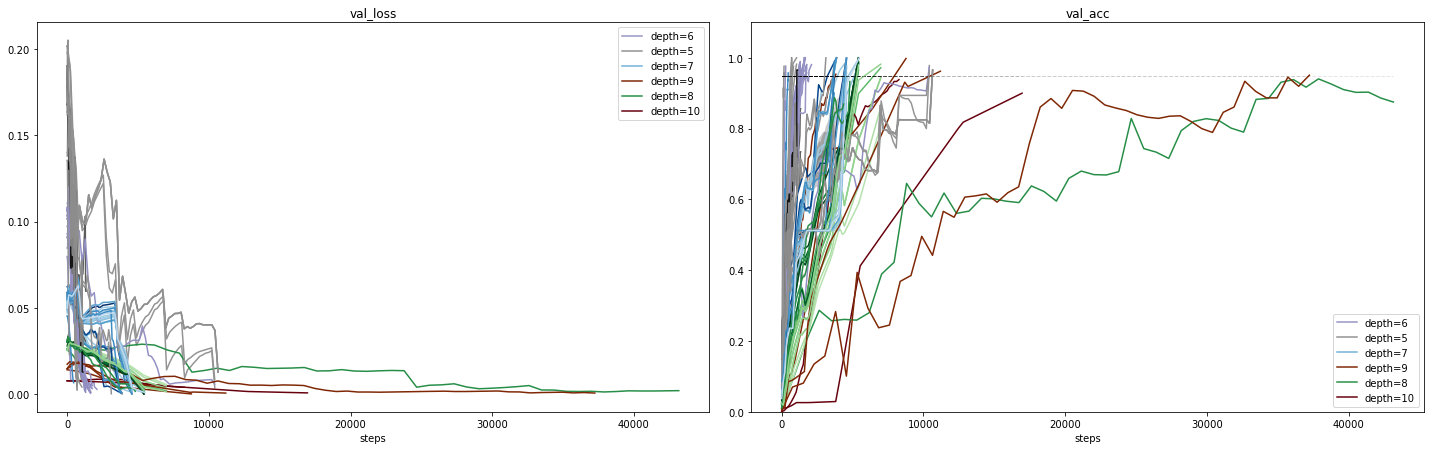

In [207]:
# loop over all files in directory

all_ckpt_dirs = os.listdir(LOG_PATH)
all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
#all_ckpt_dirs = [el for el in all_ckpt_dirs if el not in rejected_ckpts]
#all_ckpt_dirs = all_ckpt_dirs[:20]

logs_paths = [join(LOG_PATH,ckpt) for ckpt in all_ckpt_dirs]
print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
rejected_ckpts, highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, 
                                                   all_ckpt_dirs, 
                                                   name="all_plots_>0.75", tot_num_values=50, 
                                                   plot_legend=2,
                                                   threshold=0.8)
plt.show()

In [ ]:
highscore_table = sorted(highscore_table, key=lambda d: d['best_epoch'], reverse=False) 
highscore_table = sorted(highscore_table, key=lambda d: (d['best_score'], d['hidden_size']), reverse=True) 


print(highscore_table[0])

print_format_str = "{:<24} {:<4} {:<5} {:<7} {:<6} {:<4} {:<5}"

print('____________________________________________________')
print(print_format_str.format('name', 'lr', 'mode','h_size','#class', 'ep', 'best_score'))
for el in highscore_table:
    name=el['name']
    idx = [i for i in range(len(name)) if name.startswith('_', i)][3]
    name=name[idx+1:]
    print (print_format_str.format(name, el['lr'], el['mode'], el['hidden_size'], 
                                    el['nb_classes'], el['best_epoch'], el['best_score']))


# Filtered graphs

#logged paths : 6 
27141008_2404_1749_synth_rand_b0_d5_h25_lr2.0
www ../logs/27141008_2404_1749_synth_rand_b0_d5_h25_lr2.0
fold_2 val_loss 12, val_acc 12, Max_acc: 0.962 val_epoch 12, 
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 
fold_1 val_loss 14, val_acc 14, Max_acc: 0.966 val_epoch 14, 

27156821_2704_1354_synth_um_b0_d5_h25_lr2.0
www ../logs/27156821_2704_1354_synth_um_b0_d5_h25_lr2.0
fold_0 val_loss 456, val_acc 456, Max_acc: 0.966 val_epoch 456, 

27140968_2404_1655_synth_um_b1_d5_h25_lr2.0
www ../logs/27140968_2404_1655_synth_um_b1_d5_h25_lr2.0
fold_3 val_loss 10, val_acc 10, Max_acc: 1.0 val_epoch 10, 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_0 val_loss 6, val_acc 6, Max_acc: 0.997 val_epoch 6, 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27140969_2404_1655_synth_um_b10_d5_h25_lr2.0
www ../logs/27140969_2404_1655_synth_um_b10_d5_h25_lr2.0
fold_3 val_loss 10, val_acc 10, Max_acc: 1.0 val_epoch 10, 
fold_2 val_loss 12, val_acc

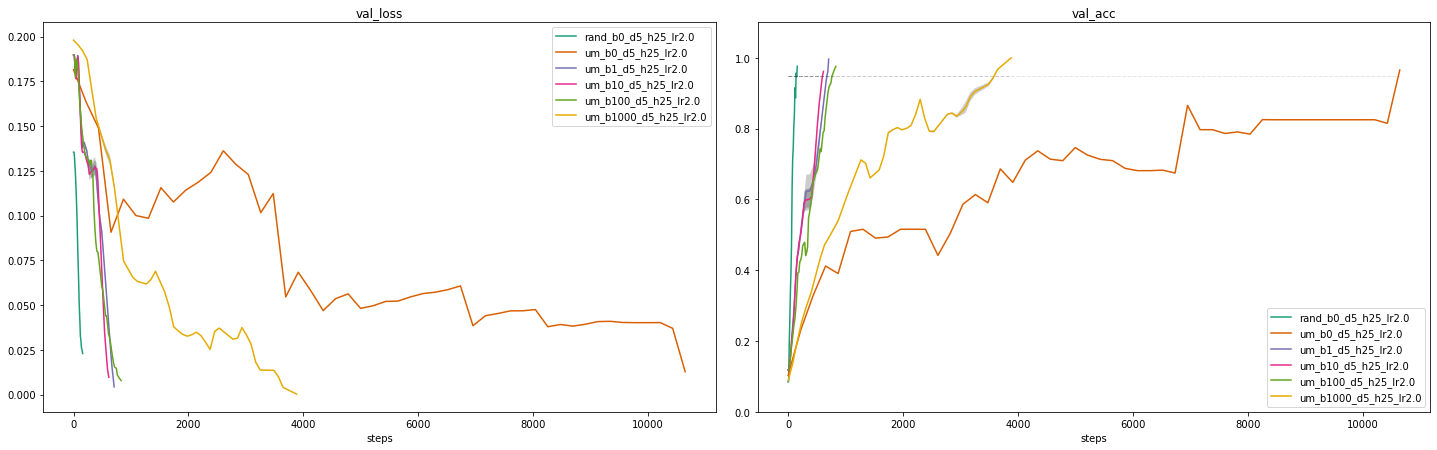

#logged paths : 1 
27126694_2004_1530_synth_um_b10_d6_h25_lr2.0
www ../logs/27126694_2004_1530_synth_um_b10_d6_h25_lr2.0
fold_0 val_loss 13, val_acc 13, Max_acc: 1.0 val_epoch 13, 



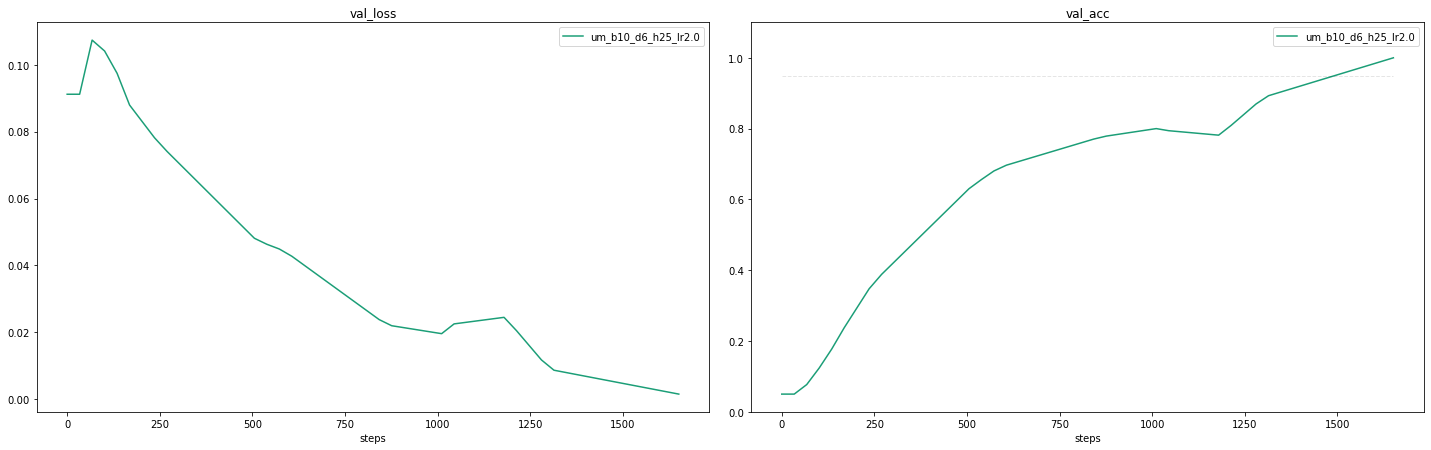

#logged paths : 6 
27146946_2504_1450_synth_rand_b0_d6_h25_lr5.0
www ../logs/27146946_2504_1450_synth_rand_b0_d6_h25_lr5.0
fold_2 val_loss 25, val_acc 25, Max_acc: 0.98 val_epoch 25, 
fold_0 val_loss 28, val_acc 28, Max_acc: 0.97 val_epoch 28, 
fold_1 val_loss 25, val_acc 25, Max_acc: 0.98 val_epoch 25, 

27147223_2504_1612_synth_um_b0_d6_h25_lr5.0
www ../logs/27147223_2504_1612_synth_um_b0_d6_h25_lr5.0
fold_0 val_loss 323, val_acc 323, Max_acc: 0.973 val_epoch 323, 

27137826_2404_1154_synth_um_b1_d6_h25_lr5.0
www ../logs/27137826_2404_1154_synth_um_b1_d6_h25_lr5.0
fold_3 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 
fold_2 val_loss 8, val_acc 8, Max_acc: 0.962 val_epoch 8, 
fold_0 val_loss 11, val_acc 11, Max_acc: 0.981 val_epoch 11, 
fold_1 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 

27137827_2404_1154_synth_um_b10_d6_h25_lr5.0
www ../logs/27137827_2404_1154_synth_um_b10_d6_h25_lr5.0
fold_3 val_loss 10, val_acc 10, Max_acc: 0.992 val_epoch 10, 
fold_2 val_loss 9, val_a

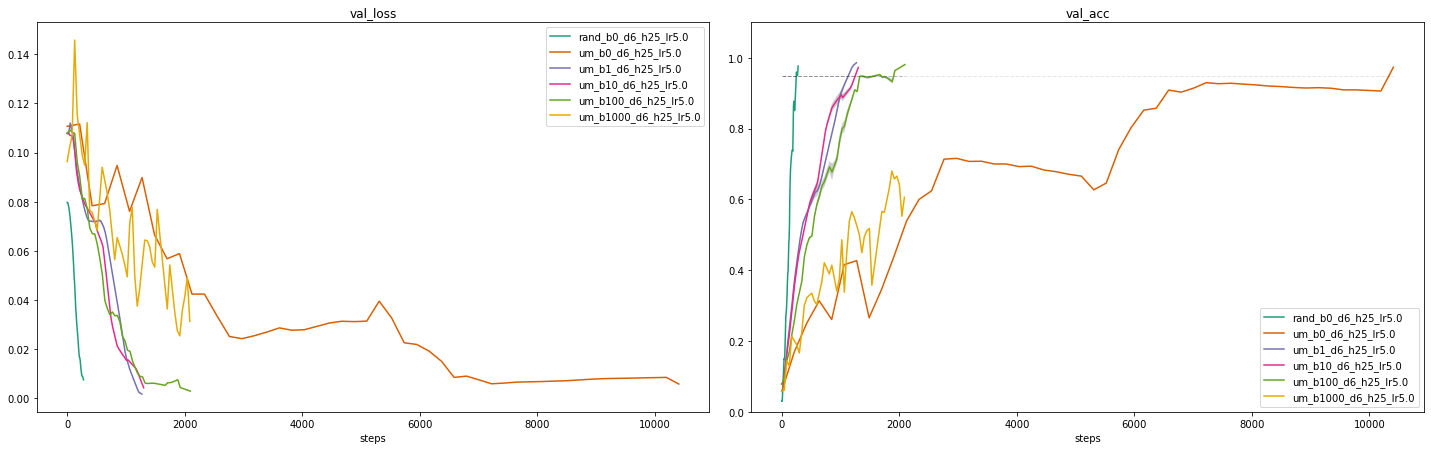

#logged paths : 5 
27149335_2604_1533_synth_um_b0_d7_h250_lr2.0
www ../logs/27149335_2604_1533_synth_um_b0_d7_h250_lr2.0
fold_0 val_loss 647, val_acc 647, Max_acc: 0.512 val_epoch 647, 
fold_1 val_loss 1142, val_acc 1142, Max_acc: 0.906 val_epoch 1142, 

27146496_2504_1409_synth_um_b1_d7_h250_lr2.0
www ../logs/27146496_2504_1409_synth_um_b1_d7_h250_lr2.0
fold_2 val_loss 12, val_acc 12, Max_acc: 0.985 val_epoch 12, 
fold_0 val_loss 23, val_acc 23, Max_acc: 0.941 val_epoch 23, 
fold_1 val_loss 20, val_acc 20, Max_acc: 0.986 val_epoch 20, 

27146501_2504_1415_synth_um_b10_d7_h250_lr2.0
www ../logs/27146501_2504_1415_synth_um_b10_d7_h250_lr2.0
fold_2 val_loss 13, val_acc 13, Max_acc: 0.969 val_epoch 13, 
fold_0 val_loss 26, val_acc 26, Max_acc: 0.99 val_epoch 26, 
fold_1 val_loss 23, val_acc 23, Max_acc: 1.0 val_epoch 23, 

27146504_2504_1416_synth_um_b100_d7_h250_lr2.0
www ../logs/27146504_2504_1416_synth_um_b100_d7_h250_lr2.0
fold_2 val_loss 28, val_acc 28, Max_acc: 0.985 val_epoch 28, 


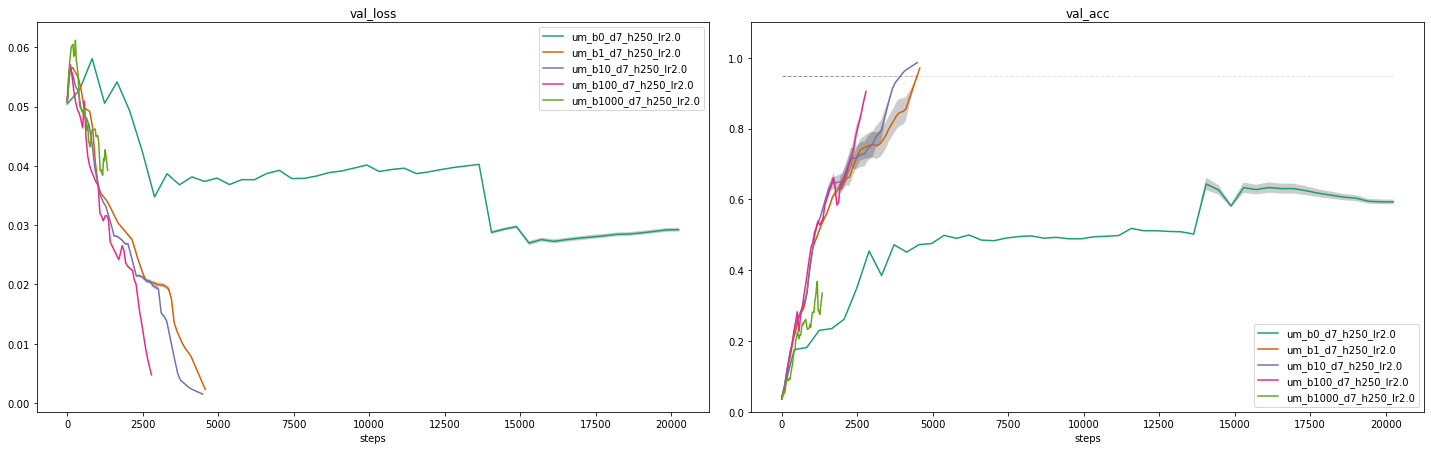

#logged paths : 4 
27146948_2504_1450_synth_rand_b0_d7_h250_lr5.0
www ../logs/27146948_2504_1450_synth_rand_b0_d7_h250_lr5.0
fold_3 val_loss 45, val_acc 45, Max_acc: 0.952 val_epoch 45, 
fold_2 val_loss 43, val_acc 43, Max_acc: 0.952 val_epoch 43, 
fold_0 val_loss 44, val_acc 44, Max_acc: 0.954 val_epoch 44, 
fold_1 val_loss 46, val_acc 46, Max_acc: 0.971 val_epoch 46, 

27147225_2504_1613_synth_um_b0_d7_h250_lr5.0
www ../logs/27147225_2504_1613_synth_um_b0_d7_h250_lr5.0
fold_0 val_loss 763, val_acc 763, Max_acc: 0.512 val_epoch 763, 

27127958_2104_1218_synth_um_b1_d7_h250_lr5.0
www ../logs/27127958_2104_1218_synth_um_b1_d7_h250_lr5.0
fold_0 val_loss 23, val_acc 23, Max_acc: 0.997 val_epoch 23, 

27135067_2304_1752_synth_um_b10_d7_h250_lr5.0
www ../logs/27135067_2304_1752_synth_um_b10_d7_h250_lr5.0
fold_0 val_loss 25, val_acc 25, Max_acc: 0.989 val_epoch 25, 



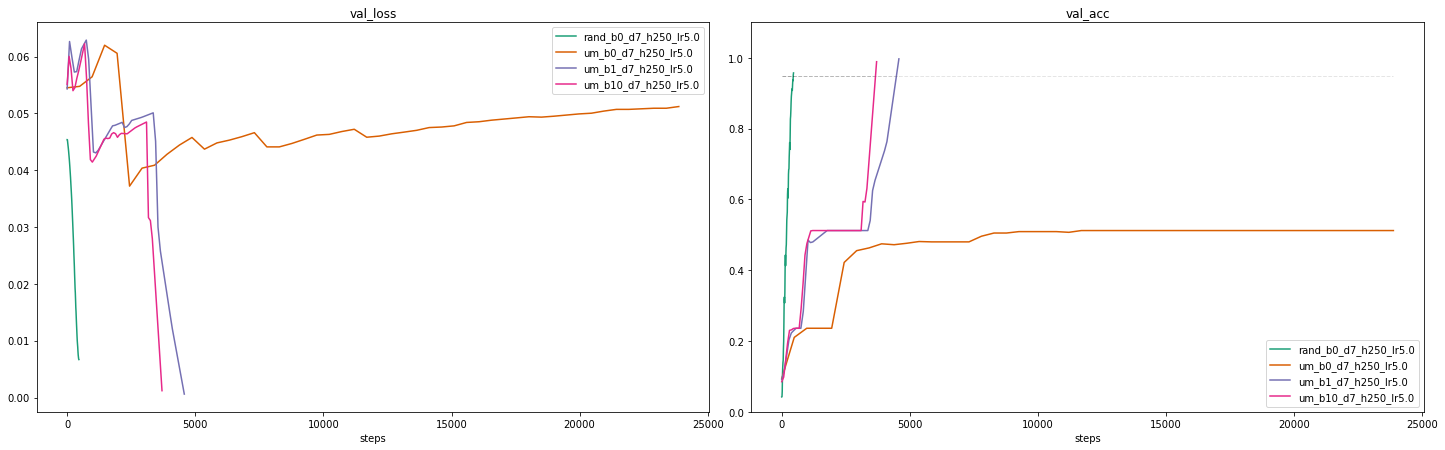

#logged paths : 6 
27146950_2504_1451_synth_rand_b0_d8_h300_lr5.0
www ../logs/27146950_2504_1451_synth_rand_b0_d8_h300_lr5.0
fold_3 val_loss 123, val_acc 123, Max_acc: 0.952 val_epoch 123, 
fold_2 val_loss 121, val_acc 121, Max_acc: 0.952 val_epoch 121, 
fold_0 val_loss 125, val_acc 125, Max_acc: 0.953 val_epoch 125, 
fold_1 val_loss 131, val_acc 131, Max_acc: 0.97 val_epoch 131, 

27147228_2504_1617_synth_um_b0_d8_h300_lr5.0
www ../logs/27147228_2504_1617_synth_um_b0_d8_h300_lr5.0
fold_0 val_loss 972, val_acc 972, Max_acc: 0.947 val_epoch 972, 

27127994_2104_1329_synth_um_b1_d8_h300_lr5.0
www ../logs/27127994_2104_1329_synth_um_b1_d8_h300_lr5.0
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 

27137832_2404_1155_synth_um_b10_d8_h300_lr5.0
www ../logs/27137832_2404_1155_synth_um_b10_d8_h300_lr5.0
fold_2 val_loss 15, val_acc 15, Max_acc: 0.877 val_epoch 15, 
fold_0 val_loss 17, val_acc 17, Max_acc: 1.0 val_epoch 17, 
fold_1 val_loss 13, val_acc 13, Max_acc: 0.951 val_epoch 1

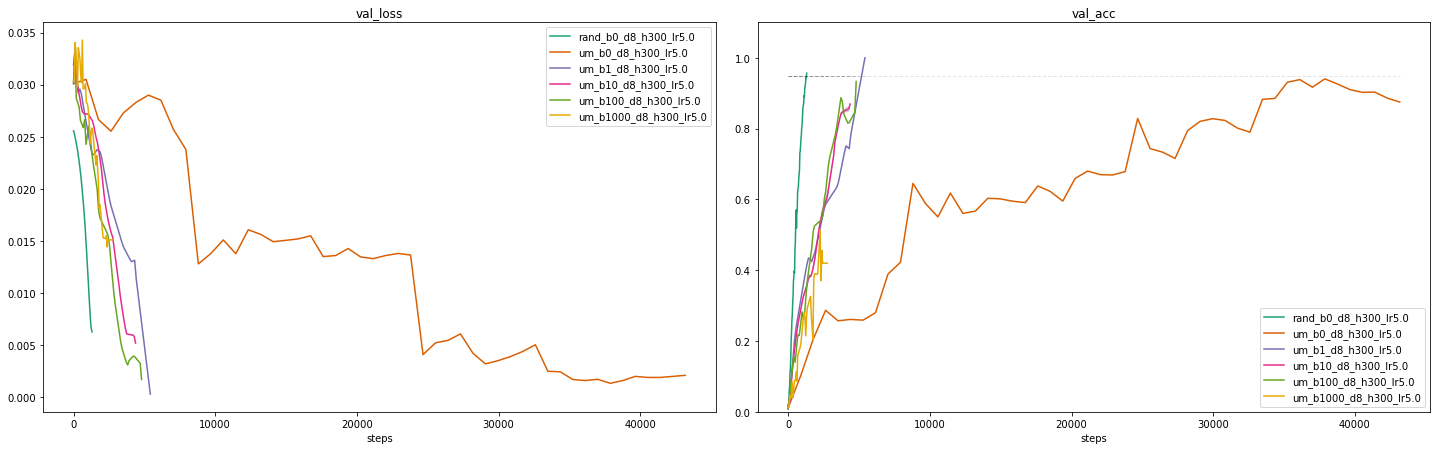

#logged paths : 3 
27146953_2504_1451_synth_rand_b0_d9_h500_lr5.0
www ../logs/27146953_2504_1451_synth_rand_b0_d9_h500_lr5.0
fold_3 val_loss 378, val_acc 378, Max_acc: 0.951 val_epoch 378, 
fold_2 val_loss 335, val_acc 335, Max_acc: 0.954 val_epoch 335, 
fold_0 val_loss 382, val_acc 382, Max_acc: 0.953 val_epoch 382, 
fold_1 val_loss 376, val_acc 376, Max_acc: 0.956 val_epoch 376, 

27147230_2504_1618_synth_um_b0_d9_h500_lr5.0
www ../logs/27147230_2504_1618_synth_um_b0_d9_h500_lr5.0
fold_0 val_loss 570, val_acc 570, Max_acc: 0.951 val_epoch 570, 

27127962_2104_1218_synth_um_b1_d9_h500_lr5.0
www ../logs/27127962_2104_1218_synth_um_b1_d9_h500_lr5.0
fold_0 val_loss 13, val_acc 13, Max_acc: 0.962 val_epoch 13, 



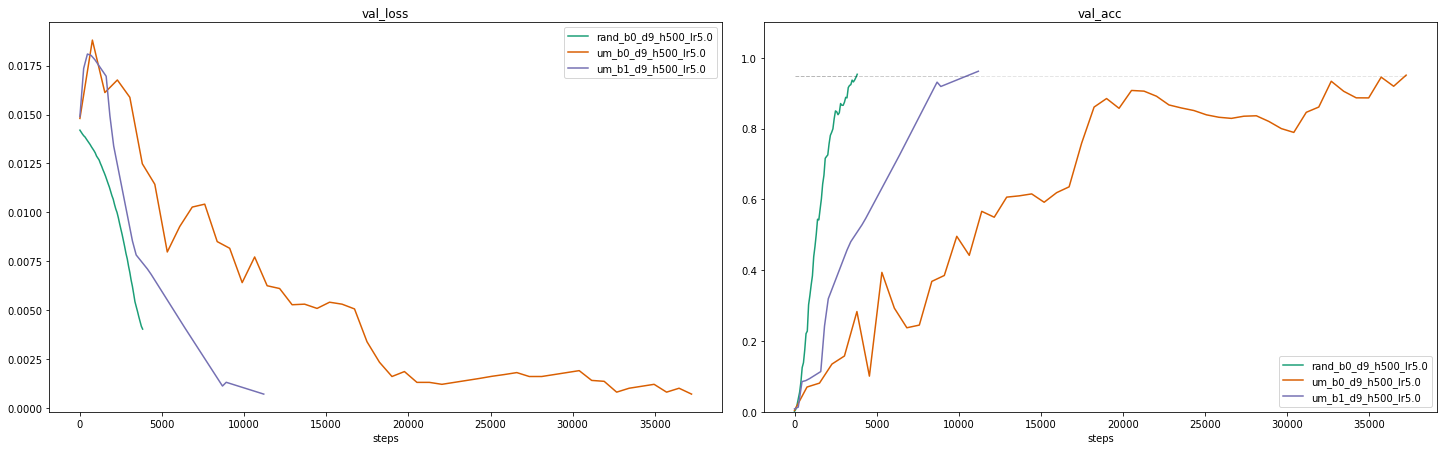

#logged paths : 5 
27156825_2704_1355_synth_rand_b0_d10_h1000_lr5.0
www ../logs/27156825_2704_1355_synth_rand_b0_d10_h1000_lr5.0
fold_2 val_loss 742, val_acc 742, Max_acc: 0.929 val_epoch 742, 
fold_0 val_loss 787, val_acc 787, Max_acc: 0.951 val_epoch 787, 
fold_1 val_loss 827, val_acc 827, Max_acc: 0.951 val_epoch 827, 

27127999_2104_1331_synth_um_b1_d10_h1000_lr5.0
www ../logs/27127999_2104_1331_synth_um_b1_d10_h1000_lr5.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.9 val_epoch 10, 

27127998_2104_1331_synth_um_b1_d10_h1000_lr2.0
www ../logs/27127998_2104_1331_synth_um_b1_d10_h1000_lr2.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.581 val_epoch 10, 

27127830_2104_1012_synth_um_b1_d10_h1000_lr1.0
www ../logs/27127830_2104_1012_synth_um_b1_d10_h1000_lr1.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.429 val_epoch 10, 

27127829_2104_1012_synth_um_b1_d10_h1000_lr0.5
www ../logs/27127829_2104_1012_synth_um_b1_d10_h1000_lr0.5
fold_0 val_loss 10, val_acc 10, Max_acc: 0.147 val_epoch 10, 



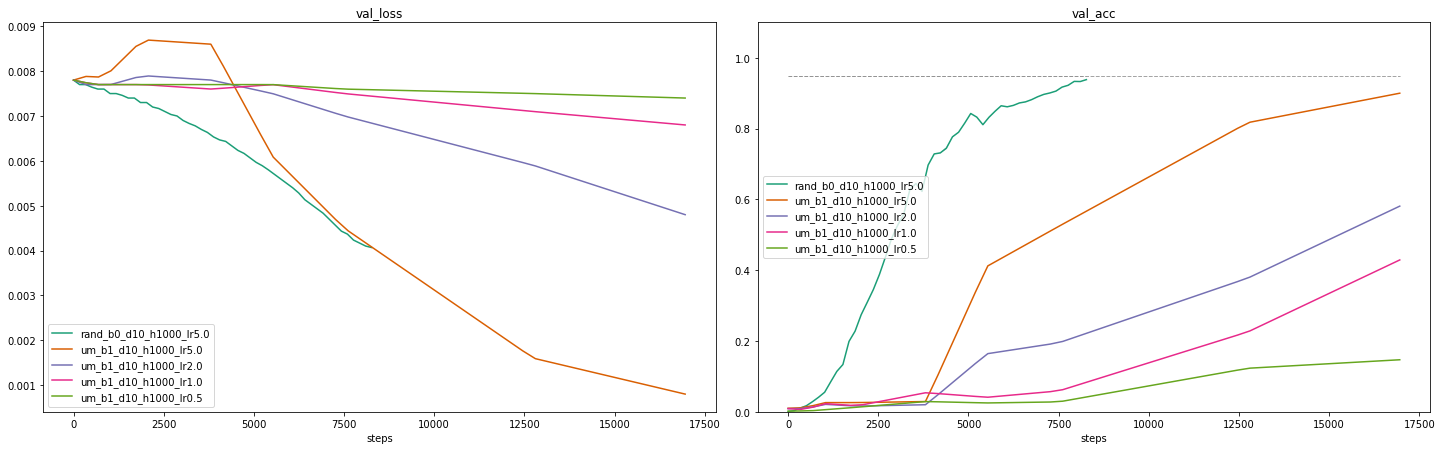

In [223]:
# example name: 27135056_2304_1747_synth_um_b1000_d5_h25_lr5


def plot_runs_w_regex(re_patt_to_search, threshold, log_path=LOG_PATH):
    plot_name=f"plot_>{threshold}_{re_patt_to_search}"
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: int(re.search('b([0-9]*)', d).group(1)), reverse=False)
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: float(re.search('lr([0-9.]*)', d).group(1)), reverse=True)

    logs_paths = [join(log_path, ckpt) for ckpt in all_ckpt_dirs]
    print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
    rejected_ckpts, highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, 
                                                       all_ckpt_dirs,
                                                       name=plot_name, tot_num_values=50, 
                                                       plot_legend=1,
                                                       threshold=threshold, color_patt='discrete')
    plt.show()

patts_to_search = ["d5_h25_lr2", "d6_h25_lr2", "d6_h25_lr5", "d7_h250_lr2", "d7_h250_lr5", "d8_h300_lr5", "d9_h500_lr5", "d10_h1000"]

for patt in patts_to_search: plot_runs_w_regex(patt, 0.1) 


#logged paths : 5 
27146929_2504_1440_synth_um_b1_d5_h25_lr10.0
fold_0 val_loss 34, val_acc 34, Max_acc: 0.0906 unsuccessful run
27137821_2404_1154_synth_um_b1_d5_h25_lr5.0
fold_3 val_loss 9, val_acc 9, Max_acc: 0.981 val_epoch 9, 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_0 val_loss 6, val_acc 6, Max_acc: 1.0 val_epoch 6, 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27140968_2404_1655_synth_um_b1_d5_h25_lr2.0
fold_3 val_loss 10, val_acc 10, Max_acc: 1.0 val_epoch 10, 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_0 val_loss 6, val_acc 6, Max_acc: 0.997 val_epoch 6, 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27146928_2504_1440_synth_um_b1_d5_h25_lr1.0
fold_3 val_loss 13, val_acc 13, Max_acc: 1.0 val_epoch 13, 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_0 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27146927_2504_1440_synth_um_b1

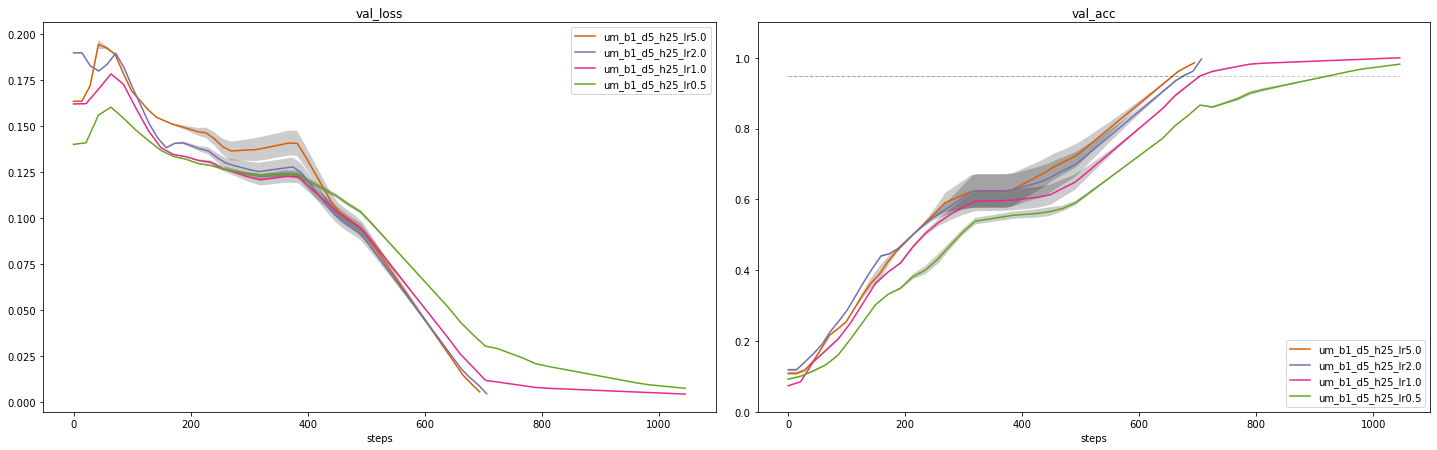

#logged paths : 2 
27137826_2404_1154_synth_um_b1_d6_h25_lr5.0
fold_3 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 
fold_2 val_loss 8, val_acc 8, Max_acc: 0.962 val_epoch 8, 
fold_0 val_loss 11, val_acc 11, Max_acc: 0.981 val_epoch 11, 
fold_1 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 

27127858_2104_1119_synth_um_b1_d6_h25_lr3.0
fold_0 val_loss 11, val_acc 11, Max_acc: 0.952 val_epoch 11, 



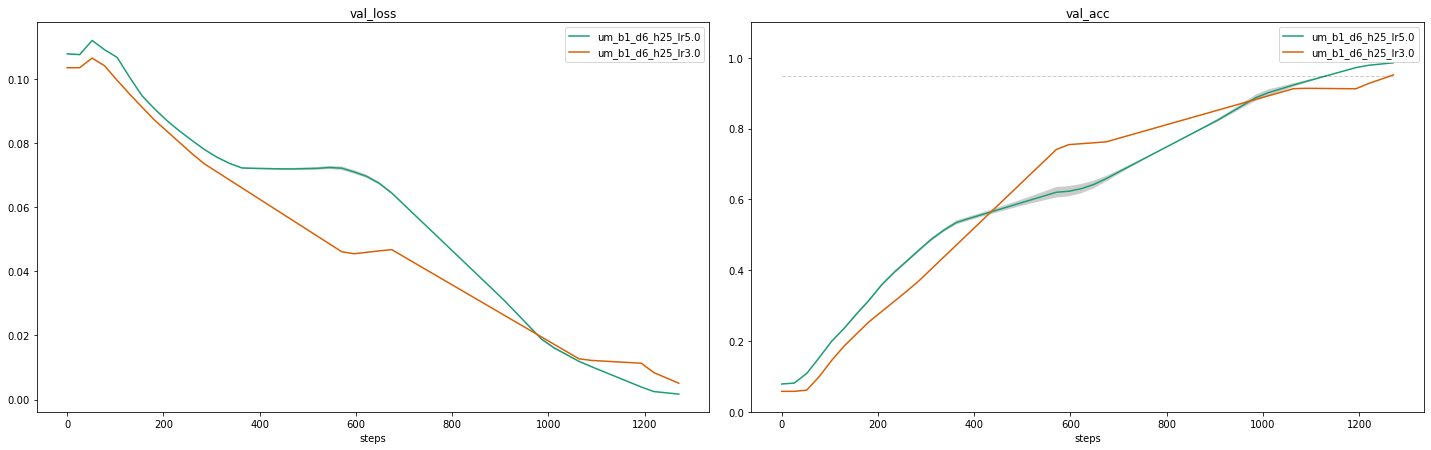

#logged paths : 5 
27127959_2104_1218_synth_um_b1_d7_h250_lr10.0
fold_0 val_loss 23, val_acc 23, Max_acc: 1.0 val_epoch 23, 

27127958_2104_1218_synth_um_b1_d7_h250_lr5.0
fold_0 val_loss 23, val_acc 23, Max_acc: 0.997 val_epoch 23, 

27127880_2104_1127_synth_um_b1_d7_h250_lr3.0
fold_0 val_loss 23, val_acc 23, Max_acc: 0.977 val_epoch 23, 

27146496_2504_1409_synth_um_b1_d7_h250_lr2.0
fold_2 val_loss 12, val_acc 12, Max_acc: 0.985 val_epoch 12, 
fold_0 val_loss 23, val_acc 23, Max_acc: 0.941 val_epoch 23, 
fold_1 val_loss 20, val_acc 20, Max_acc: 0.986 val_epoch 20, 

27127785_2104_0758_synth_um_b1_d7_h250_lr1.5
fold_0 val_loss 23, val_acc 23, Max_acc: 0.93 val_epoch 23, 



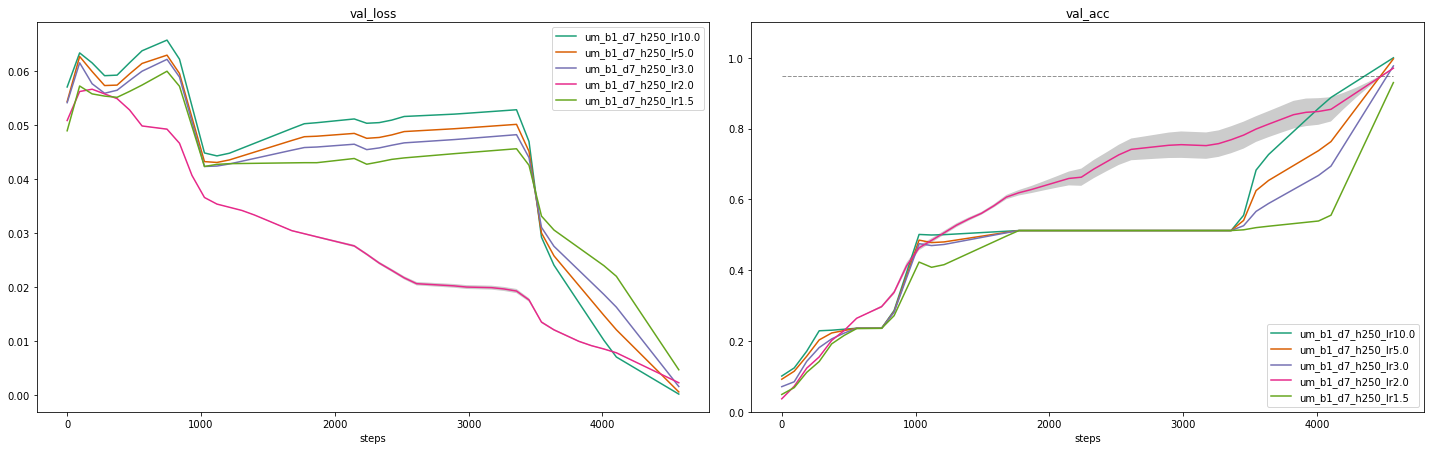

#logged paths : 4 
27147181_2504_1534_synth_um_b1_d8_h300_lr10.0
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 

27127994_2104_1329_synth_um_b1_d8_h300_lr5.0
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 

27127993_2104_1329_synth_um_b1_d8_h300_lr2.0
fold_0 val_loss 16, val_acc 16, Max_acc: 0.98 val_epoch 16, 

27147180_2504_1527_synth_um_b1_d8_h300_lr1.0
fold_0 val_loss 17, val_acc 17, Max_acc: 0.812 val_epoch 17, 



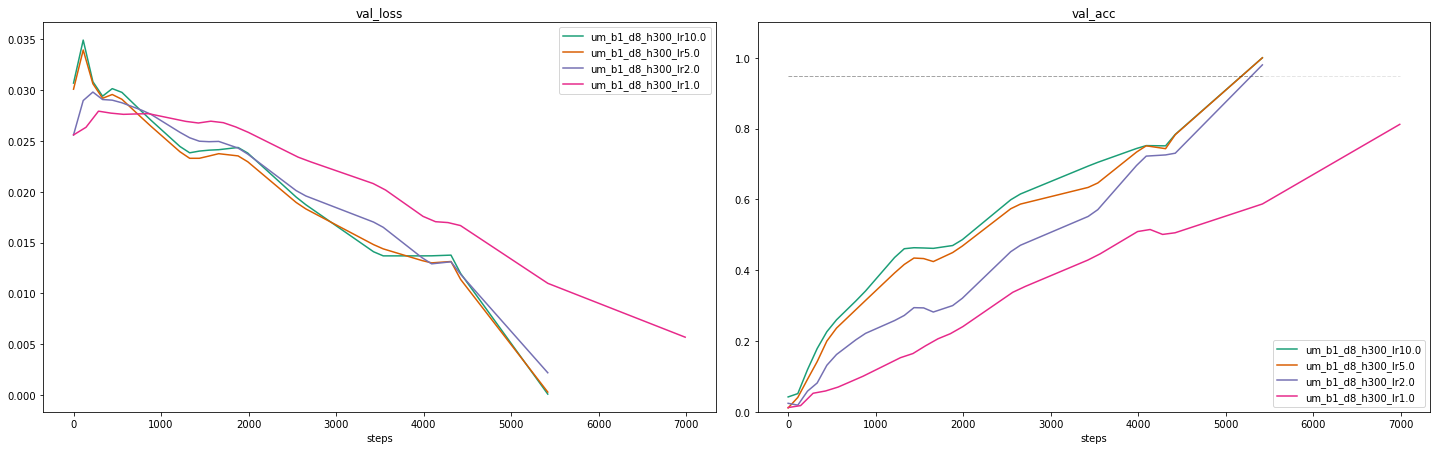

#logged paths : 5 
27127963_2104_1218_synth_um_b1_d9_h500_lr10.0
fold_0 val_loss 11, val_acc 11, Max_acc: 0.998 val_epoch 11, 

27127962_2104_1218_synth_um_b1_d9_h500_lr5.0
fold_0 val_loss 13, val_acc 13, Max_acc: 0.962 val_epoch 13, 

27127800_2104_0802_synth_um_b1_d9_h500_lr2.0
fold_0 val_loss 12, val_acc 12, Max_acc: 0.667 val_epoch 12, 

27127799_2104_0800_synth_um_b1_d9_h500_lr1.5
fold_0 val_loss 12, val_acc 12, Max_acc: 0.491 val_epoch 12, 

27127798_2104_0800_synth_um_b1_d9_h500_lr1.0
fold_0 val_loss 12, val_acc 12, Max_acc: 0.386 val_epoch 12, 



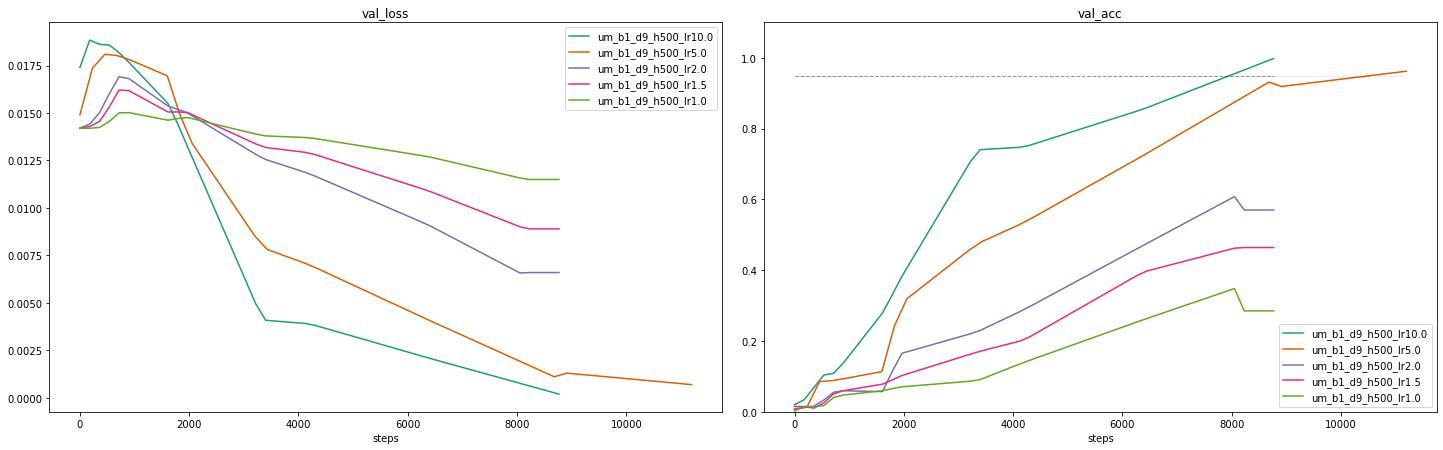

#logged paths : 5 
27156825_2704_1355_synth_rand_b0_d10_h1000_lr5.0
fold_2 val_loss 742, val_acc 742, Max_acc: 0.929 val_epoch 742, 
fold_0 val_loss 787, val_acc 787, Max_acc: 0.951 val_epoch 787, 
fold_1 val_loss 827, val_acc 827, Max_acc: 0.951 val_epoch 827, 

27127999_2104_1331_synth_um_b1_d10_h1000_lr5.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.9 val_epoch 10, 

27127998_2104_1331_synth_um_b1_d10_h1000_lr2.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.581 val_epoch 10, 

27127830_2104_1012_synth_um_b1_d10_h1000_lr1.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.429 val_epoch 10, 

27127829_2104_1012_synth_um_b1_d10_h1000_lr0.5
fold_0 val_loss 10, val_acc 10, Max_acc: 0.147 val_epoch 10, 



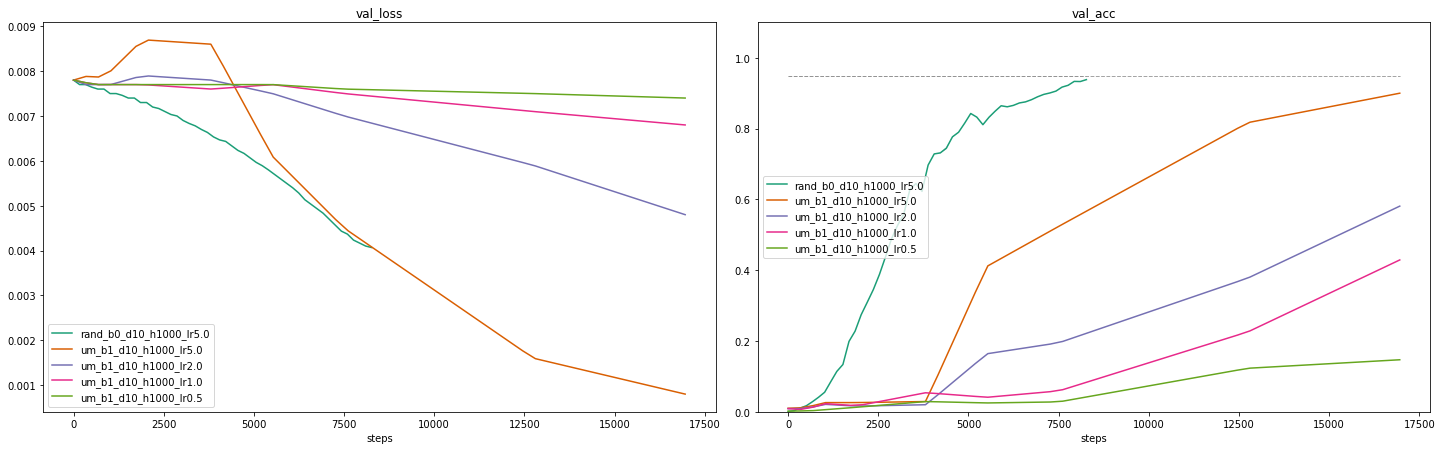

In [215]:
patts_to_search = ["b1_d5_h25_lr", "b1_d6_h25_lr",  "b1_d7_h250_lr", "b1_d8_h300_lr", "b1_d9_h500_lr", "d10_h1000"]

for patt in patts_to_search: plot_runs_w_regex(patt, 0.1) 

#logged paths : 5 
27156823_2704_1355_synth_um_b0_d5_h25_lr10.0
fold_0 val_loss 1504, val_acc 1504, Max_acc: 0.1 unsuccessful run
27156822_2704_1355_synth_um_b0_d5_h25_lr5.0
fold_0 val_loss 1502, val_acc 1502, Max_acc: 0.103 unsuccessful run
27156821_2704_1354_synth_um_b0_d5_h25_lr2.0
fold_0 val_loss 456, val_acc 456, Max_acc: 0.966 val_epoch 456, 

27156820_2704_1354_synth_um_b0_d5_h25_lr1.0
fold_0 val_loss 444, val_acc 444, Max_acc: 0.962 val_epoch 444, 

27156819_2704_1354_synth_um_b0_d5_h25_lr0.5
fold_0 val_loss 444, val_acc 444, Max_acc: 0.978 val_epoch 444, 



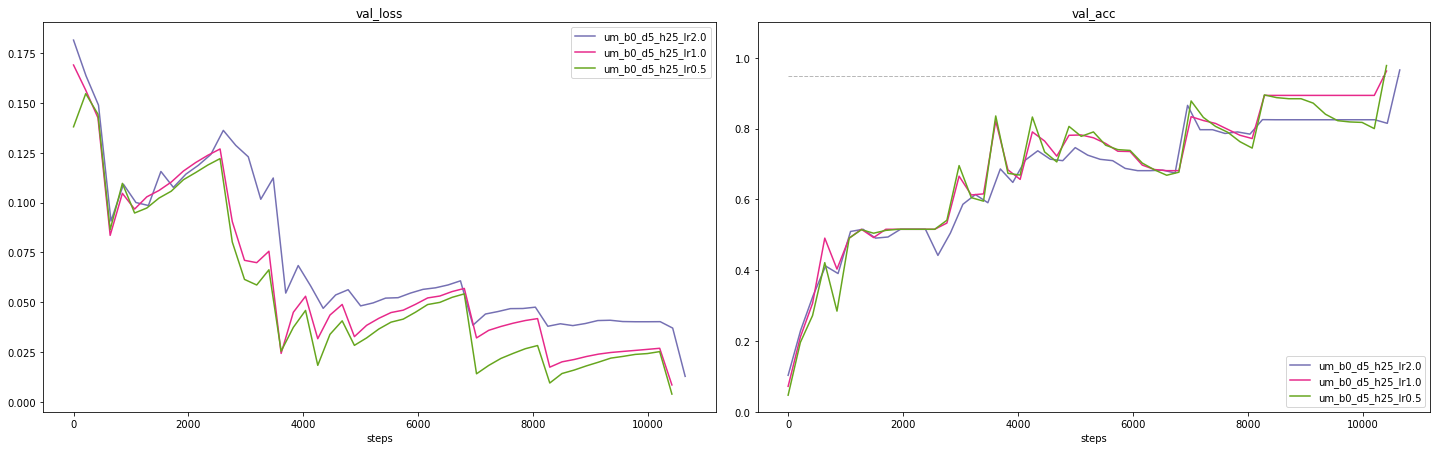

#logged paths : 1 
27147223_2504_1612_synth_um_b0_d6_h25_lr5.0
fold_0 val_loss 323, val_acc 323, Max_acc: 0.973 val_epoch 323, 



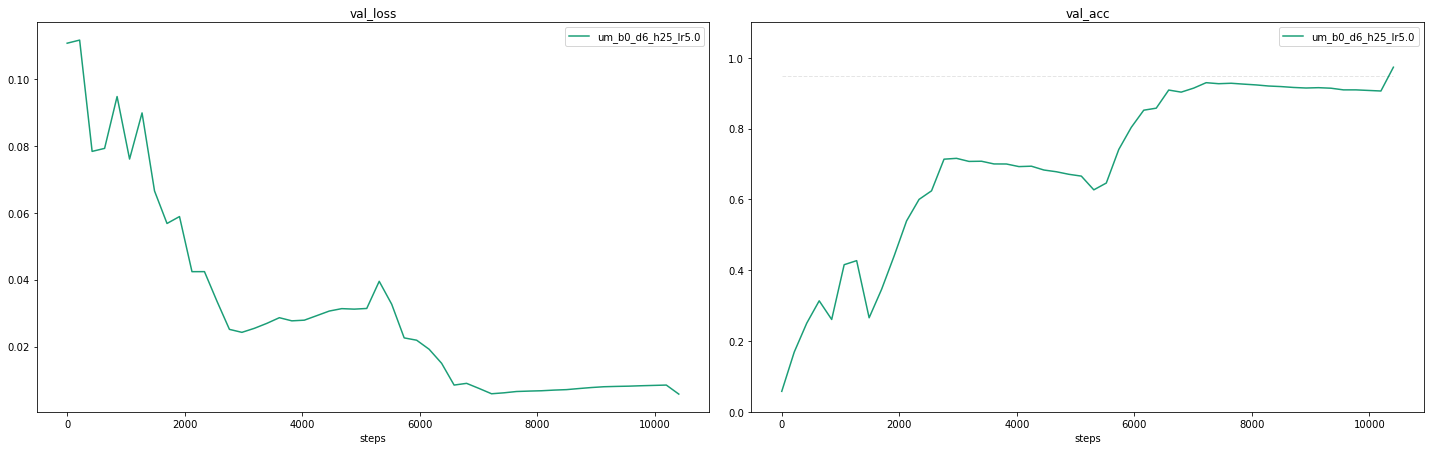

#logged paths : 4 
27149336_2604_1539_synth_um_b0_d7_h250_lr10.0
fold_0 val_loss 763, val_acc 763, Max_acc: 0.512 val_epoch 763, 
fold_1 val_loss 1351, val_acc 1351, Max_acc: 0.922 val_epoch 1351, 

27147225_2504_1613_synth_um_b0_d7_h250_lr5.0
fold_0 val_loss 763, val_acc 763, Max_acc: 0.512 val_epoch 763, 

27149335_2604_1533_synth_um_b0_d7_h250_lr2.0
fold_0 val_loss 647, val_acc 647, Max_acc: 0.512 val_epoch 647, 
fold_1 val_loss 1142, val_acc 1142, Max_acc: 0.906 val_epoch 1142, 

27149333_2604_1532_synth_um_b0_d7_h250_lr1.0
fold_0 val_loss 646, val_acc 646, Max_acc: 0.512 val_epoch 646, 
fold_1 val_loss 1142, val_acc 1142, Max_acc: 0.906 val_epoch 1142, 



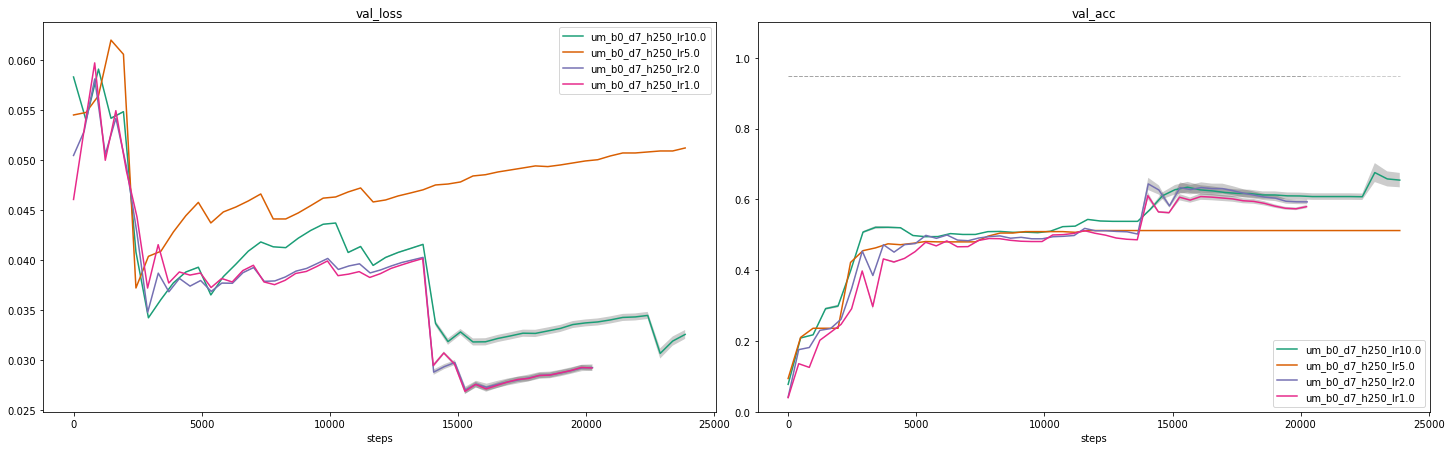

#logged paths : 1 
27147228_2504_1617_synth_um_b0_d8_h300_lr5.0
fold_0 val_loss 972, val_acc 972, Max_acc: 0.947 val_epoch 972, 



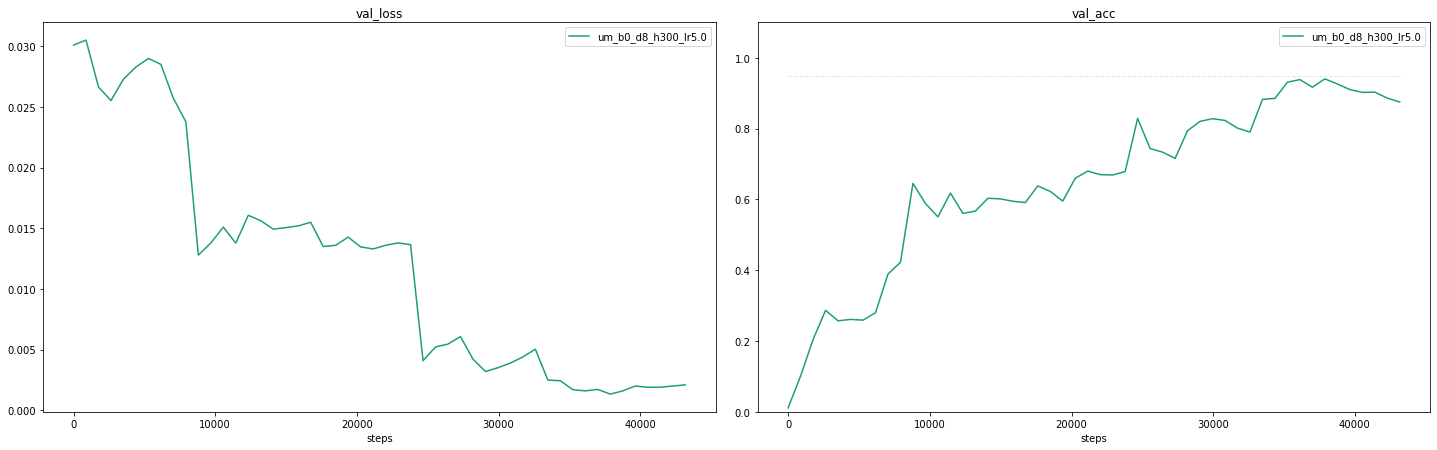

#logged paths : 1 
27147230_2504_1618_synth_um_b0_d9_h500_lr5.0
fold_0 val_loss 570, val_acc 570, Max_acc: 0.951 val_epoch 570, 



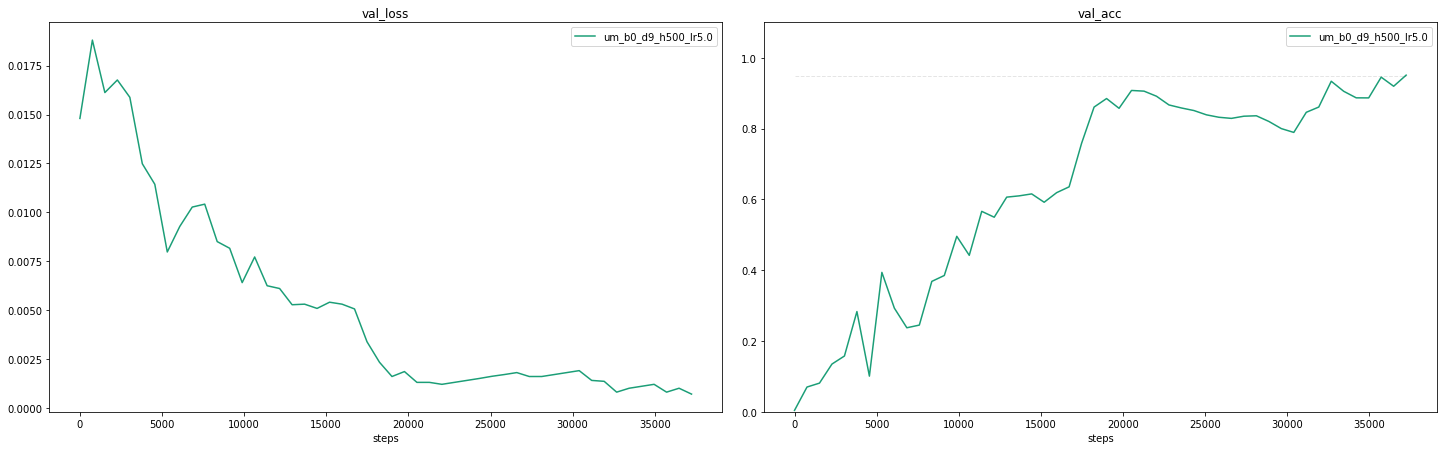

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#logged paths : 0 


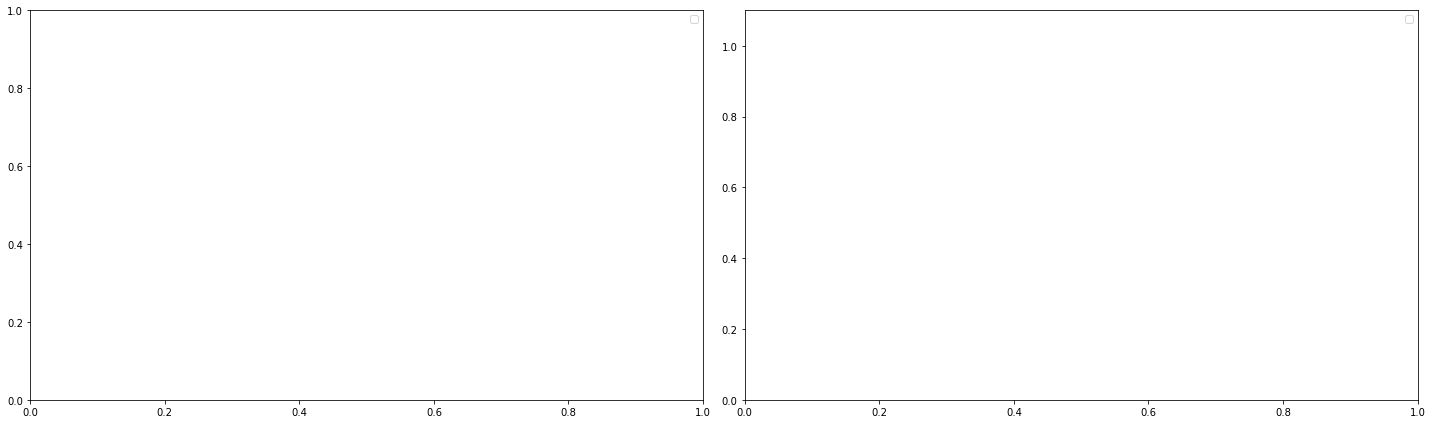

In [217]:
patts_to_search = ["um_b0_d5_h25_lr", "um_b0_d6_h25_lr",  "um_b0_d7_h250_lr", "um_b0_d8_h300_lr", "um_b0_d9_h500_lr", "um_b0_d10_h1000_lr"]
for patt in patts_to_search: plot_runs_w_regex(patt, 0.5) 

#logged paths : 9 
27149295_2604_1445_synth_um_b1000_d5_h50_lr2.0
fold_0 val_loss 1, unsuccessful run
27140971_2404_1655_synth_um_b1000_d5_h25_lr2.0
fold_2 val_loss 24, val_acc 24, Max_acc: 0.572 val_epoch 24, 
fold_0 val_loss 48, val_acc 48, Max_acc: 0.75 val_epoch 48, 
fold_1 val_loss 49, val_acc 49, Max_acc: 0.637 val_epoch 49, 

27156751_2704_1159_synth_um_b1000_d5_h25_lr2.0
fold_0 warning: val_loss not in logs warning: val_acc not in logs warning: val_epoch not in logs 

27156752_2704_1159_synth_um_b1000_d5_h25_lr2.0
fold_1 warning: val_loss not in logs warning: val_acc not in logs warning: val_epoch not in logs 

27147173_2504_1517_synth_um_b1000_d5_h100_lr2.0
fold_0 val_loss 44, val_acc 44, Max_acc: 0.884 val_epoch 44, 

27156817_2704_1354_synth_um_b1000_d5_h25_lr2.0
fold_0 val_loss 15, val_acc 15, Max_acc: 1.0 val_epoch 15, 
fold_1 val_loss 19, val_acc 19, Max_acc: 1.0 val_epoch 19, 

27156816_2704_1349_synth_um_b1000_d5_h25_lr2.0
fold_0 val_loss 15, val_acc 15, Max_acc: 1.0 va

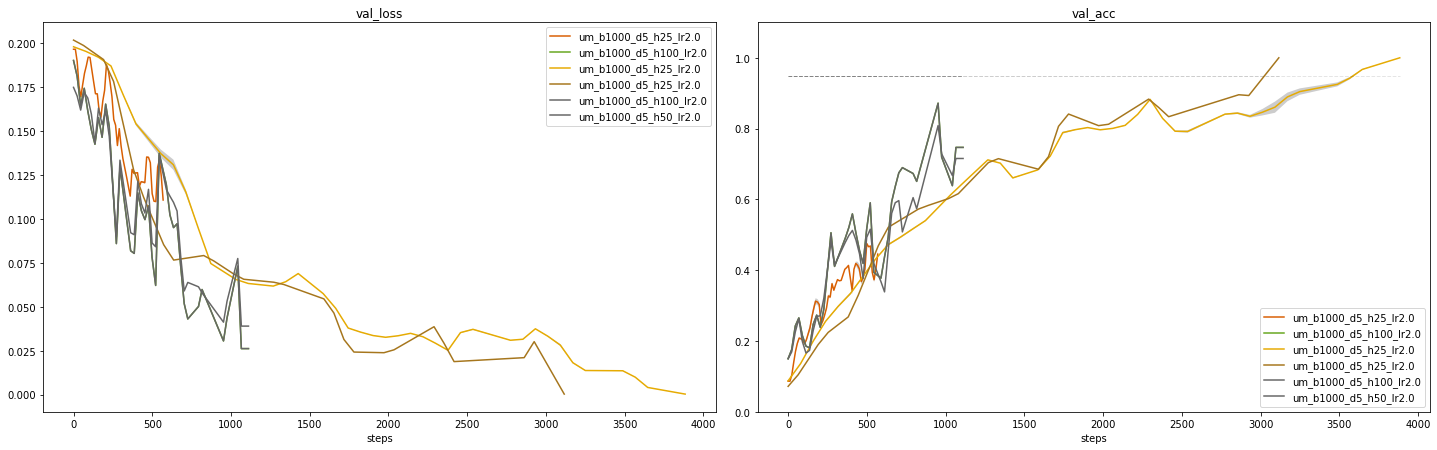

#logged paths : 5 
27149336_2604_1539_synth_um_b0_d7_h250_lr10.0
fold_0 val_loss 763, val_acc 763, Max_acc: 0.512 val_epoch 763, 
fold_1 val_loss 1351, val_acc 1351, Max_acc: 0.922 val_epoch 1351, 

27149339_2604_1541_synth_um_b0_d7_h150_lr5.0
fold_0 val_loss 849, val_acc 849, Max_acc: 0.512 val_epoch 849, 

27147225_2504_1613_synth_um_b0_d7_h250_lr5.0
fold_0 val_loss 763, val_acc 763, Max_acc: 0.512 val_epoch 763, 

27149335_2604_1533_synth_um_b0_d7_h250_lr2.0
fold_0 val_loss 647, val_acc 647, Max_acc: 0.512 val_epoch 647, 
fold_1 val_loss 1142, val_acc 1142, Max_acc: 0.906 val_epoch 1142, 

27149333_2604_1532_synth_um_b0_d7_h250_lr1.0
fold_0 val_loss 646, val_acc 646, Max_acc: 0.512 val_epoch 646, 
fold_1 val_loss 1142, val_acc 1142, Max_acc: 0.906 val_epoch 1142, 



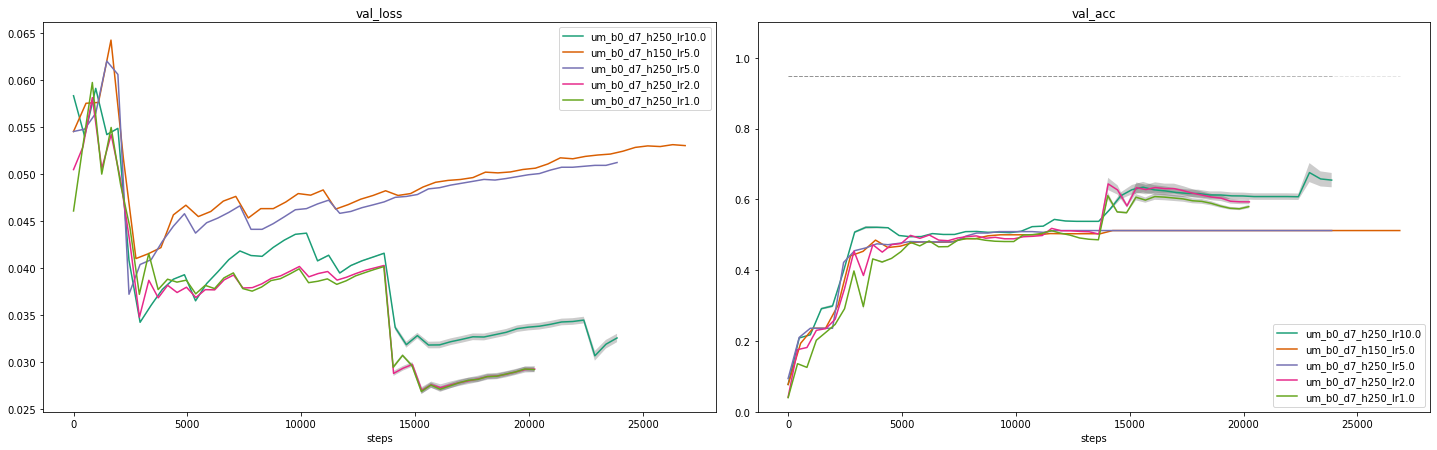

In [205]:

patts_to_search = ["b1000_d5_h[0-9]*_lr2", "um_b0_d7_h"]
for patt in patts_to_search: plot_runs_w_regex(patt, 0.5) 

#logged paths : 4 
27158432_2704_2337_synth_rand_b0_d5_h25_lr10.0
www ../dl_logs/27158432_2704_2337_synth_rand_b0_d5_h25_lr10.0
fold_2 val_loss 1504, val_acc 1504, Max_acc: 0.272 val_epoch 1504, 
fold_0 val_loss 1507, val_acc 1507, Max_acc: 0.25 val_epoch 1507, 
fold_1 val_loss 1503, val_acc 1503, Max_acc: 0.188 unsuccessful run
27158431_2704_2337_synth_rand_b0_d5_h25_lr5.0
www ../dl_logs/27158431_2704_2337_synth_rand_b0_d5_h25_lr5.0
fold_2 val_loss 9, val_acc 9, Max_acc: 0.997 val_epoch 9, 
fold_0 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_1 val_loss 12, val_acc 12, Max_acc: 0.978 val_epoch 12, 

27158430_2704_2336_synth_rand_b0_d5_h25_lr2.0
www ../dl_logs/27158430_2704_2336_synth_rand_b0_d5_h25_lr2.0
fold_2 val_loss 12, val_acc 12, Max_acc: 0.962 val_epoch 12, 
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 
fold_1 val_loss 14, val_acc 14, Max_acc: 0.966 val_epoch 14, 

27158429_2704_2336_synth_rand_b0_d5_h25_lr1.0
www ../dl_logs/27158429_2704_2336_synth_ra

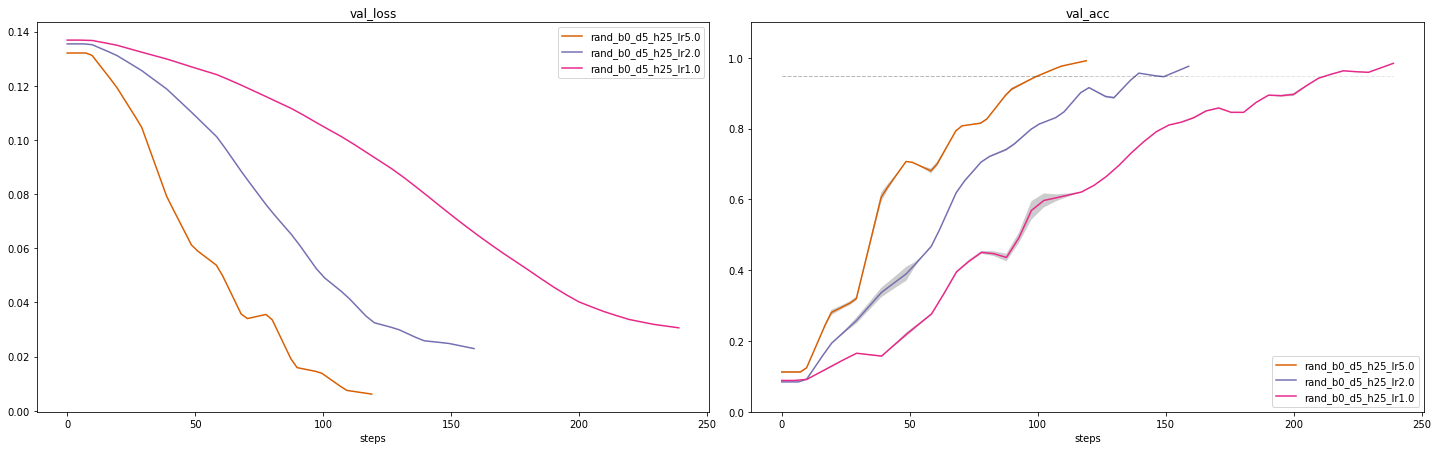

#logged paths : 4 
27158436_2704_2337_synth_rand_b0_d6_h25_lr10.0
www ../dl_logs/27158436_2704_2337_synth_rand_b0_d6_h25_lr10.0
fold_2 val_loss 21, val_acc 21, Max_acc: 0.991 val_epoch 21, 
fold_0 val_loss 22, val_acc 22, Max_acc: 0.955 val_epoch 22, 
fold_1 val_loss 20, val_acc 20, Max_acc: 0.952 val_epoch 20, 

27158435_2704_2337_synth_rand_b0_d6_h25_lr5.0
www ../dl_logs/27158435_2704_2337_synth_rand_b0_d6_h25_lr5.0
fold_2 val_loss 25, val_acc 25, Max_acc: 0.98 val_epoch 25, 
fold_0 val_loss 28, val_acc 28, Max_acc: 0.97 val_epoch 28, 
fold_1 val_loss 25, val_acc 25, Max_acc: 0.98 val_epoch 25, 

27158434_2704_2337_synth_rand_b0_d6_h25_lr2.0
www ../dl_logs/27158434_2704_2337_synth_rand_b0_d6_h25_lr2.0
fold_2 val_loss 36, val_acc 36, Max_acc: 0.956 val_epoch 36, 
fold_0 val_loss 47, val_acc 47, Max_acc: 0.969 val_epoch 47, 
fold_1 val_loss 43, val_acc 43, Max_acc: 0.978 val_epoch 43, 

27158433_2704_2337_synth_rand_b0_d6_h25_lr1.0
www ../dl_logs/27158433_2704_2337_synth_rand_b0_d6_h25

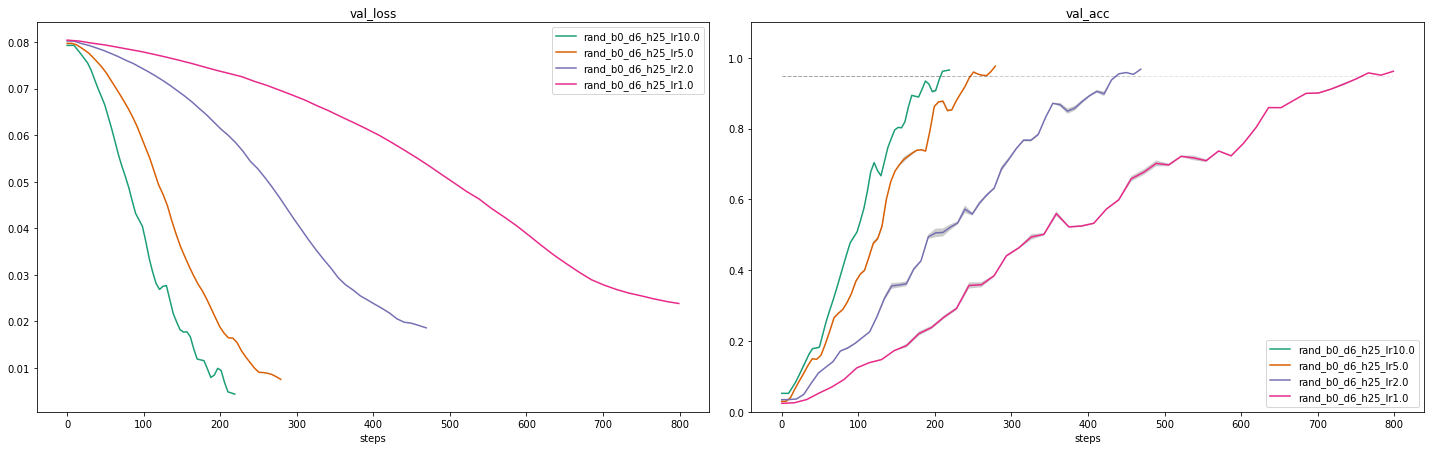

#logged paths : 4 
27158441_2704_2340_synth_rand_b0_d7_h50_lr10.0
www ../dl_logs/27158441_2704_2340_synth_rand_b0_d7_h50_lr10.0
fold_2 val_loss 39, val_acc 39, Max_acc: 0.958 val_epoch 39, 
fold_0 val_loss 38, val_acc 38, Max_acc: 0.962 val_epoch 38, 
fold_1 val_loss 40, val_acc 40, Max_acc: 0.958 val_epoch 40, 

27158440_2704_2339_synth_rand_b0_d7_h50_lr5.0
www ../dl_logs/27158440_2704_2339_synth_rand_b0_d7_h50_lr5.0
fold_2 val_loss 63, val_acc 63, Max_acc: 0.951 val_epoch 63, 
fold_0 val_loss 59, val_acc 59, Max_acc: 0.974 val_epoch 59, 
fold_1 val_loss 60, val_acc 60, Max_acc: 0.967 val_epoch 60, 

27158439_2704_2338_synth_rand_b0_d7_h50_lr2.0
www ../dl_logs/27158439_2704_2338_synth_rand_b0_d7_h50_lr2.0
fold_2 val_loss 125, val_acc 125, Max_acc: 0.966 val_epoch 125, 
fold_0 val_loss 111, val_acc 111, Max_acc: 0.96 val_epoch 111, 
fold_1 val_loss 115, val_acc 115, Max_acc: 0.955 val_epoch 115, 

27158438_2704_2338_synth_rand_b0_d7_h50_lr1.0
www ../dl_logs/27158438_2704_2338_synth_ran

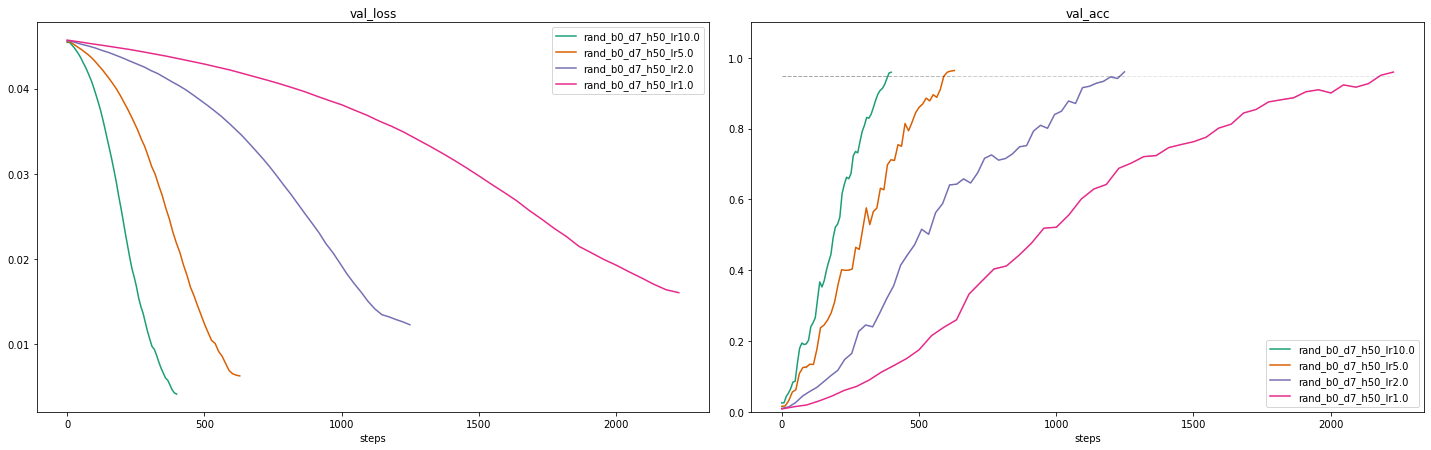

#logged paths : 4 
27158454_2704_2346_synth_rand_b0_d8_h100_lr10.0
www ../dl_logs/27158454_2704_2346_synth_rand_b0_d8_h100_lr10.0
fold_2 val_loss 101, val_acc 101, Max_acc: 0.962 val_epoch 101, 
fold_0 val_loss 100, val_acc 100, Max_acc: 0.957 val_epoch 100, 
fold_1 val_loss 100, val_acc 100, Max_acc: 0.958 val_epoch 100, 

27158453_2704_2346_synth_rand_b0_d8_h100_lr5.0
www ../dl_logs/27158453_2704_2346_synth_rand_b0_d8_h100_lr5.0
fold_2 val_loss 163, val_acc 163, Max_acc: 0.958 val_epoch 163, 
fold_0 val_loss 168, val_acc 168, Max_acc: 0.956 val_epoch 168, 
fold_1 val_loss 159, val_acc 159, Max_acc: 0.956 val_epoch 159, 

27158452_2704_2346_synth_rand_b0_d8_h100_lr2.0
www ../dl_logs/27158452_2704_2346_synth_rand_b0_d8_h100_lr2.0
fold_2 val_loss 364, val_acc 364, Max_acc: 0.954 val_epoch 364, 
fold_0 val_loss 348, val_acc 348, Max_acc: 0.954 val_epoch 348, 
fold_1 val_loss 352, val_acc 352, Max_acc: 0.962 val_epoch 352, 

27158451_2704_2345_synth_rand_b0_d8_h100_lr1.0
www ../dl_logs/27

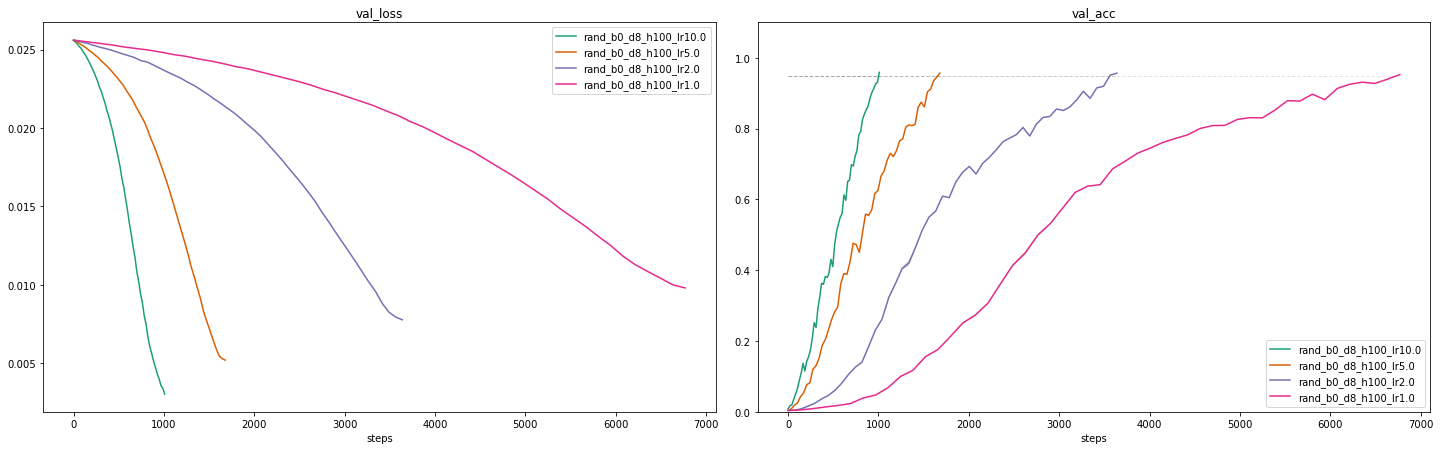

#logged paths : 2 
27158383_2704_2319_synth_um_b0_d5_h25_lr2.0
www ../dl_logs/27158383_2704_2319_synth_um_b0_d5_h25_lr2.0
fold_2 val_loss 400, val_acc 400, Max_acc: 0.969 val_epoch 400, 

27158382_2704_2318_synth_um_b0_d5_h25_lr2.0
www ../dl_logs/27158382_2704_2318_synth_um_b0_d5_h25_lr2.0
fold_1 val_loss 428, val_acc 428, Max_acc: 0.953 val_epoch 428, 



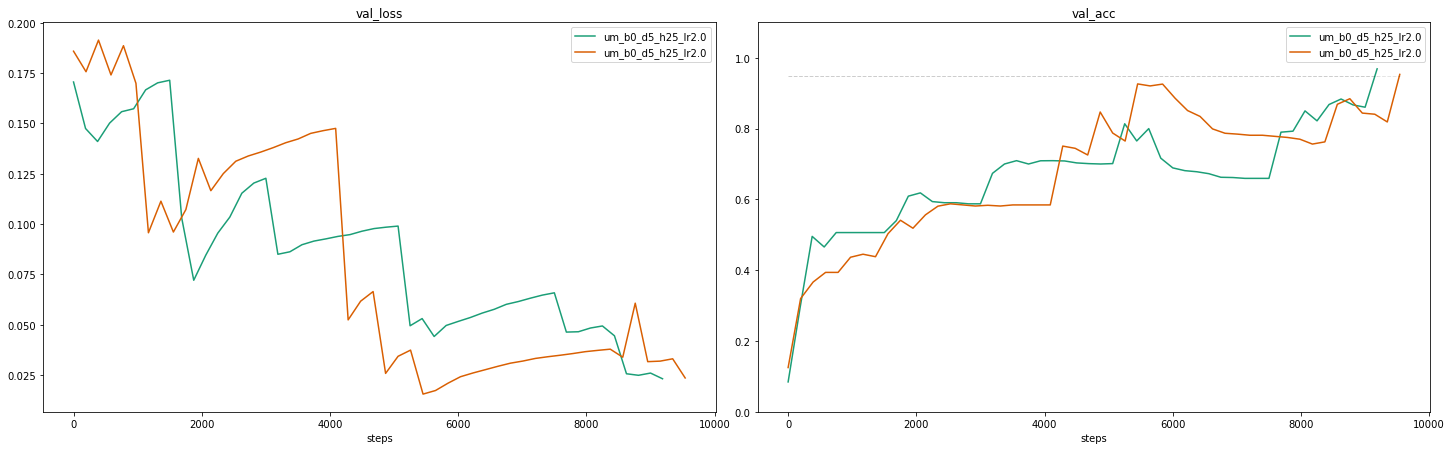

#logged paths : 8 
27158427_2704_2333_synth_um_b0_d6_h25_lr10.0
www ../dl_logs/27158427_2704_2333_synth_um_b0_d6_h25_lr10.0
fold_1 val_loss 1501, val_acc 1501, Max_acc: 0.0422 unsuccessful run
27158426_2704_2333_synth_um_b0_d6_h25_lr10.0
www ../dl_logs/27158426_2704_2333_synth_um_b0_d6_h25_lr10.0
fold_0 val_loss 1516, val_acc 1516, Max_acc: 0.0797 unsuccessful run
27158425_2704_2334_synth_um_b0_d6_h25_lr5.0
www ../dl_logs/27158425_2704_2334_synth_um_b0_d6_h25_lr5.0
fold_1 val_loss 458, val_acc 458, Max_acc: 0.978 val_epoch 458, 

27158424_2704_2334_synth_um_b0_d6_h25_lr5.0
www ../dl_logs/27158424_2704_2334_synth_um_b0_d6_h25_lr5.0
fold_0 val_loss 323, val_acc 323, Max_acc: 0.973 val_epoch 323, 

27158423_2704_2334_synth_um_b0_d6_h25_lr2.0
www ../dl_logs/27158423_2704_2334_synth_um_b0_d6_h25_lr2.0
fold_1 val_loss 379, val_acc 379, Max_acc: 0.969 val_epoch 379, 

27158422_2704_2333_synth_um_b0_d6_h25_lr2.0
www ../dl_logs/27158422_2704_2333_synth_um_b0_d6_h25_lr2.0
fold_0 val_loss 196, va

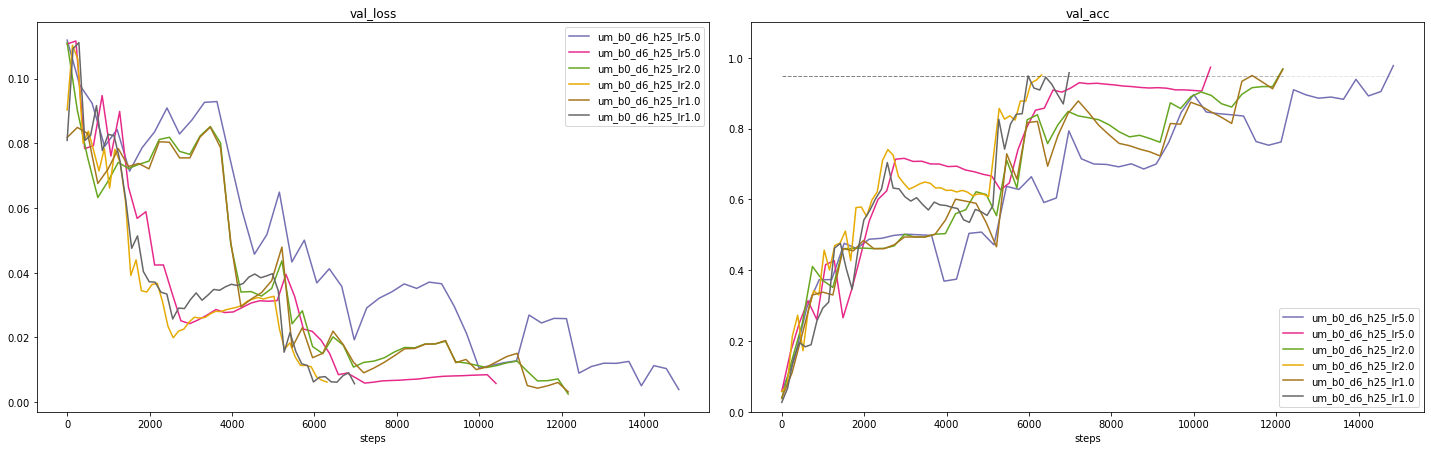

#logged paths : 6 
27157673_2704_2312_synth_um_b0_d7_h100_lr15.0
www ../dl_logs/27157673_2704_2312_synth_um_b0_d7_h100_lr15.0
fold_0 val_loss 1954, val_acc 1954, Max_acc: 0.881 val_epoch 1954, 

27157674_2704_2312_synth_um_b0_d7_h100_lr15.0
www ../dl_logs/27157674_2704_2312_synth_um_b0_d7_h100_lr15.0
fold_1 val_loss 1965, val_acc 1965, Max_acc: 0.859 val_epoch 1965, 

27157671_2704_2312_synth_um_b0_d7_h100_lr10.0
www ../dl_logs/27157671_2704_2312_synth_um_b0_d7_h100_lr10.0
fold_0 val_loss 1999, val_acc 1999, Max_acc: 0.928 val_epoch 1999, 

27157672_2704_2312_synth_um_b0_d7_h100_lr10.0
www ../dl_logs/27157672_2704_2312_synth_um_b0_d7_h100_lr10.0
fold_1 val_loss 1867, val_acc 1867, Max_acc: 0.961 val_epoch 1867, 

27157669_2704_2312_synth_um_b0_d7_h100_lr5.0
www ../dl_logs/27157669_2704_2312_synth_um_b0_d7_h100_lr5.0
fold_0 val_loss 1812, val_acc 1812, Max_acc: 0.954 val_epoch 1812, 

27157670_2704_2312_synth_um_b0_d7_h100_lr5.0
www ../dl_logs/27157670_2704_2312_synth_um_b0_d7_h100_lr5.

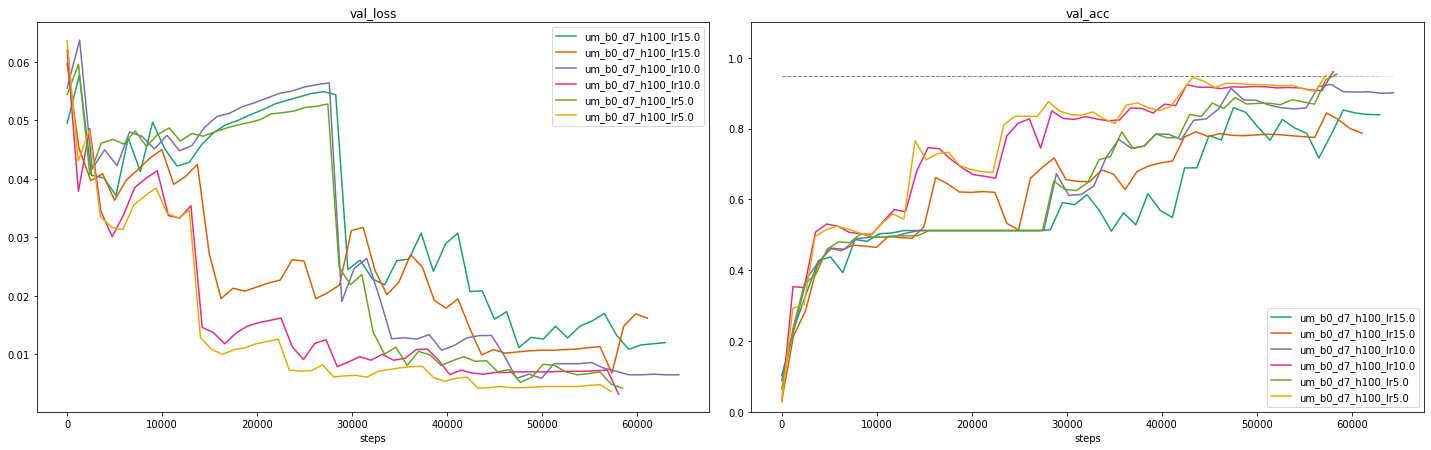

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#logged paths : 0 


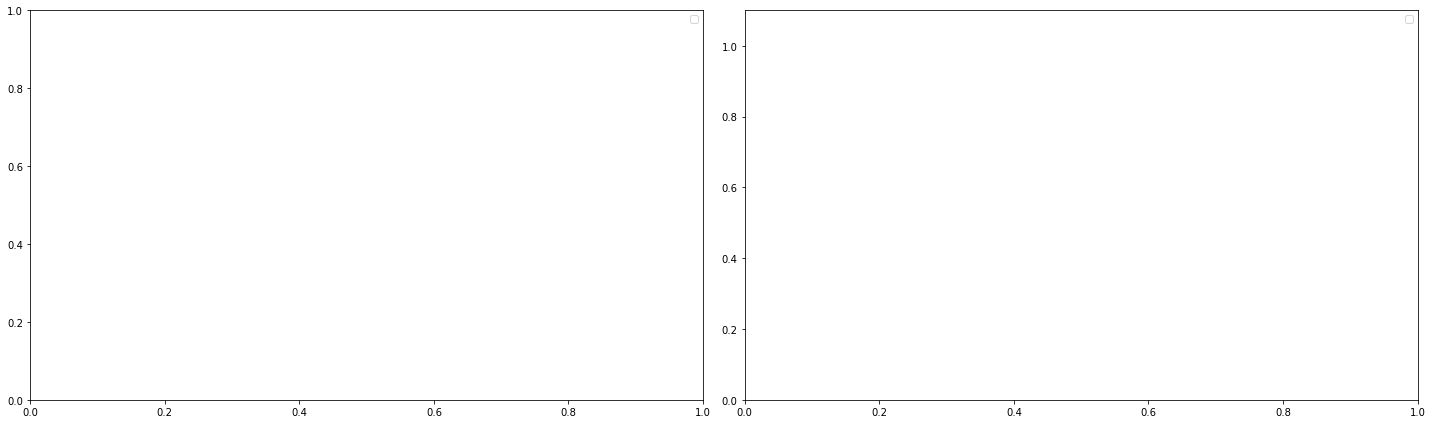

In [233]:

patts_to_search1 = ["rand[a-z0-9_]*d5","rand[a-z0-9_]*d6",
                   "rand[a-z0-9_]*d7_h50", "rand[a-z0-9_]*d8_h100"]
patts_to_search2 = ["um_b0[a-z0-9_]*d5_h25","um_b0[a-z0-9_]*d6_h25",
                   "um_b0[a-z0-9_]*d7_h100", "um_b0[a-z0-9_]*d8_h100"]
for patt in patts_to_search1: plot_runs_w_regex(patt, 0.2, DL_LOG_PATH) 
for patt in patts_to_search2: plot_runs_w_regex(patt, 0.2, DL_LOG_PATH) 

# Log folds merger

In [206]:
import shutil
import itertools
from collections import Counter
from more_itertools import locate

def merge_folds():
    all_ckpt_dirs = os.listdir(LOG_PATH)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    #all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    patt = "([0-9]+)_[0-9]+_[0-9]+_[a-z]+_((?:um|rand)_b[0-9]+_d[0-9]+_h[0-9]+_lr[0-9]+)"
    matched = [re.match(patt, el) for el in all_ckpt_dirs]
    idx_true = [int(m.group(1)) > 27146425 for m in matched] # keep only recent matches
    matched = np.array(matched)[idx_true]
    all_ckpt_dirs = np.array(all_ckpt_dirs)[idx_true]
    hashes = [el.group(2) for el in matched] # create hashes
    counts = Counter(hashes)
    dup_hashes = [i for i in counts.keys() if counts[i] > 1] # keep only ckpts w duplicates
    
    folds_to_merge = [all_ckpt_dirs[list(locate(hashes, lambda x: x == hash1))] for hash1 in dup_hashes] # get the actual paths
    print(folds_to_merge)
    
    all_ckpt_dirs = [[join(LOG_PATH, fold, 'metrics') for fold in folds] for folds in folds_to_merge]
    for folds in all_ckpt_dirs: 
        for fold in folds: assert(os.path.isdir(fold))
    
    for folds in all_ckpt_dirs:
        dest_folder = folds[0]
        fold_name = [el for el in os.listdir(dest_folder) if "DS_Store" not in el][0]
        merged_folds_nb = [int(re.match('fold_([0-9]+)', fold_name).group(1))]
        
        for fold in folds[1:]:
            folder = os.listdir(fold)
            folder = [el for el in folder if "DS_Store" not in el]
            foldnb2 = int(re.match('fold_([0-9]+)', folder[0]).group(1))
            folder = join(fold, folder[0])
            print('dest_fold_nb',merged_folds_nb, 'foldnb2', folder, foldnb2)
            if not foldnb2 in merged_folds_nb:
                merged_folds_nb.append(foldnb2)
                shutil.move(folder, dest_folder)
                
                folder = folder[:folder[:folder.rfind('/')].rfind('/')]
                shutil.rmtree(folder)
    
#27147228_2504_1617_synth_um_b0_d8_h300_lr5
merge_folds()


[array(['27149290_2604_1439_synth_um_b0_d5_h25_lr2.0',
       '27147221_2504_1612_synth_um_b0_d5_h25_lr2.0',
       '27156821_2704_1354_synth_um_b0_d5_h25_lr2.0'], dtype='<U48'), array(['27146955_2504_1451_synth_rand_b0_d10_h1000_lr5.0',
       '27156825_2704_1355_synth_rand_b0_d10_h1000_lr5.0'], dtype='<U48'), array(['27156754_2704_1202_synth_um_b1000_d6_h25_lr5.0',
       '27156809_2704_1349_synth_um_b1000_d6_h25_lr5.0',
       '27156755_2704_1203_synth_um_b1000_d6_h25_lr5.0',
       '27156810_2704_1349_synth_um_b1000_d6_h25_lr5.0'], dtype='<U48'), array(['27156751_2704_1159_synth_um_b1000_d5_h25_lr2.0',
       '27156752_2704_1159_synth_um_b1000_d5_h25_lr2.0',
       '27156817_2704_1354_synth_um_b1000_d5_h25_lr2.0',
       '27156816_2704_1349_synth_um_b1000_d5_h25_lr2.0'], dtype='<U48')]
dest_fold_nb [0] foldnb2 ../logs/27147221_2504_1612_synth_um_b0_d5_h25_lr2.0/metrics/fold_0 0
dest_fold_nb [0] foldnb2 ../logs/27156821_2704_1354_synth_um_b0_d5_h25_lr2.0/metrics/fold_0 0
dest_fold_n